# Introduction
ABCGAN (atmospheric background characterization 'GAN') is a generative adversarial network that reproduces realistic physical profiles of the upper atmosphere and ionosphere. Unlike traditional empirical models, ABCGAN can produce not only the average profile under particular conditions, but also the expected distribution of parameters. This allows the GAN to estimate the probability that a given profile is part of the historical distribution, enabling it to determine if an event is highly unusual (outside the range of "normal" atmospheric variation).

The model was trained on historical measurements collected from the Poker Flat Incoherent Scattering Radar (PFISR) from 2007-2020. PFISR measures profiles of the scalar plasma parameters electron density (Ne), electron temperature (Te), and ion temperature (Ti) in the ionosphere. For more information about the training data, visit amisr.com.

ABCGAN is valid for predicting average ionospheric parameters over Poker Flat, AK.  The results should also be reasonable for most locations in the auroral zone, but caution should be exercised using the GAN results in other latitude regimes.

# Tutorial Outline

This demo provides a demonstration of the abcgan project. This includes using our BV/HFP GAN models to generate atmospheric
background profiles/gravity waves consistent with the historically observed distribution and detecting statistical anomalies
the historically observed atmospheric data. The entire outline of the tutorial is listed below.

- Import ABCGAN
- Import Data
    - External Drivers
    * Background Variables
    * High Frequency Perturbations
* Generating Background Profiles & HFP Waves
    * Generating BVs and HFPs
    * Sampling the Generator
* Exploring Model Results
    * Evaluating Model Performance
    * Comparing Real vs Generated
* Driver Estimation
* Anomaly Detection
    * Background
    * N-Dim Estimation
    * BV Anomaly Example
    * HFP Anomaly Example
* Attention Maps
    * BV Self-Attention Maps
    * HFP Attention Map
* TEC Waves
    * LSTIDs GAN (Poker Flats)
    * MSTIDs GAN (Mt Moses)

# Import ABCGAN & Python Modules

Several imports are used. In particular, we load `numpy`, which provides the formats for data input output. We also use the numpy library for calculation of statistics and simulating fake data. We load `abcgan` which contains modules for generating atmospheric data, evaluating model performing, estimating anomaly scores, and analysing model behaviors. We also load `matplotlib.pyplot`, `seaborn`, and `pandas` for display.

In [1]:
import numpy as np  # numerics
import abcgan  # abcgan package
import matplotlib.pyplot as plt  # plotting
import matplotlib
import seaborn as sns  # plotting
import pandas as pd  # plotting
import datetime
import matplotlib.image as mpimg
import abcgan.constants as const
from abcgan.interface import estimate_drivers
from abcgan.mask import prev_driver_mask
from abcgan.interface import generate_bvs, generate_hfps, generate_multi_bv, generate_multi_hfp
from abcgan.anomaly import anomaly_score_bv, anomaly_score_hfp, anomaly_score_wtec
from abcgan.interface import load_h5_data, load_wtec_h5, generate_wtec, generate_multi_wtec
from abcgan.attention import collect_bv_attn_map, collect_hfp_attn_map
from abcgan.interface import hellinger_scores_bv, hellinger_scores_hfp, hellinger_scores_wtec

# Import Data

We can load all the data using the `load_h5_data`, which takes care of reading data from the h5 file and filtering out any invalid samples. You can pass in the number of samples to load along with the file name and the function returns numpy arrays of driver parameters, background variables, altitude profile mask for the background variables, HFP waves, HFP wave mask, and the unix time stamp of each sample.


In [2]:
fname = 'tutorial_isr.h5'
drivers, bvs, alt_mask, hfps, wave_mask, unix_time = load_h5_data(fname, n_samples=1000, random_start=True, load_hfp=True)
print(f"Drivers Shape : {drivers.shape}")
print(f"Background Variables Shape : {bvs.shape}")
print(f"Alt Mask Shape : {alt_mask.shape}")
print(f"Background Variables Shape : {hfps.shape}")
print(f"Alt Mask Shape : {wave_mask.shape}")
print(f"Unix Time Stamp Shape : {unix_time.shape}")

Drivers Shape : (1000, 29)
Background Variables Shape : (1000, 30, 12)
Alt Mask Shape : (1000, 30)
Background Variables Shape : (1000, 1, 8)
Alt Mask Shape : (1000, 1)
Unix Time Stamp Shape : (1000,)


## External Drivers

Our GAN models take the external drivers, which describe the current environmental conditions, and outputs generated background profiles and/or hfp waves. We currently are using 29 external drivers, which are listed and described below


In [3]:
print(f"Number of Drivers: {drivers.shape[-1]}")
print(f"Drivers Names: {const.driver_names}")

Number of Drivers: 29
Drivers Names: ['Ap', 'F10.7', 'F10.7avg', 'MEI', 'MLT', 'RMM1', 'RMM2', 'SLT', 'SZA', 'ShadHeight', 'T10', 'T100', 'T2', 'T30', 'T5', 'T70', 'TCI', 'U10', 'U100', 'U2', 'U30', 'U5', 'U70', 'ap', 'dst', 'moon_phase', 'moon_x', 'moon_y', 'moon_z']



The list of drivers keys printed above corresponds to the following physical parameters:

| Key               | Full Name                      | Description                                                                                               |
|-------------------|--------------------------------|-----------------------------------------------------------------------------------------------------------|
| SLT               | Solar Local Time               | Local time as determined by the sun's position                                                            |
| MLT               | Magnetic Local Time            | Local time calculated used magnetic coordinate system                                                     |
| SZA               | Solar Zenith Angle             | Angle between the sun and local zenith                                                                    |
| ShadHeight        | Shadow Height                  | Height of the Earth's shadow in the atmosphere                                                            |
| moon_x            | Lunar Position - x             | X component of Lunar position in ECEF coordinates                                                         |
| moon_y            | Lunar Position - y             | Y component of Lunar position in ECEF coordinates                                                         |
| moon_z            | Lunar Position - z             | Z component of Lunar position in ECEF coordinates                                                         |
| moon_phase        | Lunar Phase                    | Lunar phase in degrees                                                                                    |
| ap                | ap Geomagnetic Index           | Three hour equivilent planetary amplitude                                                                 |
| Ap                | Daily Ap Index                 | Daily equivalent planetary aplitude                                                                       |
| F10.7             | F10.7 Solar Radio Flux         | Solar rado flux at 10.7 cm (2800 MHz) in s.f.u (10^-22 W m^-2 Hz^-1)                                      |
| F10.7a            | Average F10.7 Solar Radio Flux | Average solar rado flux at 10.7 cm (2800 MHz) in s.f.u (10^-22 W m^-2 Hz^-1)                              |
| TCI               | Thermosphere Climate Index     | 60-day running average of global cooling power radiated from the thermosphere                             |
| MEI               | Multivariate ESNO Index        | Measure of the El Nino/Southern Oscillation (ESNO)/sea surface temperature                                |
| RMM1              | First MJO Index                | First component of the Madden-Julian Osscillation Indices                                                 |
| RMM2              | Second MJO Index               | Second component of the Madden-Julian Osscillation Indices                                                |
| U2/5/10/30/70/100 | Mean zonal winds               | mean zonal winds (eastward) at at altitudes with pressures 2,5,10,30,70, and 100 hPa                      |
| T2/5/10/30/70/100 | Mean Stratospheric Temps       | Stratospheric northern hemisphere mean (60 - 90 lat) at altitudes with pressures 2,5,10,30,70, and 100 hPa |
| dst               | Distrurbance storm time index  | index of magnetic activity that measures the intensity of the globally symmetrical equatorial electrojet  |



Each driver is stored as a separate vector in `tutorial_isr.h5`, where each entry in the vector is a separate sample. So the full set of drivers for the first sample consists of the first element in each vector.The `load_h5_data` function collates all the drivers samples into a single data structure which has size nSamples x nDrivers, in the order specified by `abcgan.driver_names`.

See the tutorial on generating and saving drivers in this directory for how to create a driver file.

## High Frequency Perturbations (HFPs)

The HFPs data describes atmospheric gravity waves found in the background variable data. Waves are not always present, which is indicated by nans in hfp dataset. The `wave_mask` also indicates whether a wave is present or not at each sample and we can see that only around half the samples have waves. Currently our dataset only allows up to one wave to be present at each sample thus the 2nd dim, which indicates the list of waves, will always be 1.

In [4]:
print(f'HFP Shape: {hfps.shape}')
print(f'{hfps.shape[0]} Samples')
print(f'{hfps.shape[2]} HFP variables')
print(const.hfp_names)
print(f'\nPercentage of Samples with Waves: {wave_mask.sum()/len(wave_mask):.2f}')

HFP Shape: (1000, 1, 8)
1000 Samples
8 HFP variables
['GW_tau', 'GW_lamh', 'GW_lamv', 'GW_ch', 'GW_cv', 'GW_phi', 'GW_hl', 'GW_hu']

Percentage of Samples with Waves: 0.41



The list of hfps variables printed above corresponds to the following physical parameters:

| Key        | Full Name                                               | Description                                                                  |
| ---------- | --------------------------------------------------------|----------------------------------------------------------------------------- |
| GW_tau     | GW period in minutes                                    | Period using PFISR 5-min integrated nenotr F-region Ne perturbations                              |
| GW_lamh    | GW horizontal wavelength in km                          | Horizontal wavelength using PFISR 5-min integrated nenotr F-region Ne perturbations|
| GW_lamv    | GW vertical wavelength in km                            | Vertical wavelength using PFISR 5-min integrated nenotr F-region Ne perturbations|
| GW_ch      | GW horizontal phase speed in m/s                        | Horizontal phase speed using PFISR 5-min integrated nenotr F-region Ne perturbations|
| GW_cv      | GW vertical phase speed in m/s                          | Vertical phase speed using PFISR 5-min integrated nenotr F-region Ne perturbations|
| GW_phi     | GW horizontal propagation direction in azimuth degrees  | Horizontal propagation direction using PFISR 5-min integrated nenotr F-region Ne perturbations|
| GW_hl      | GW lower altitude boundary in km                        | Lower altitude where the wave was detected|
| GW_hu      | GW upper altitude boundary in km                        | Higher altitude where the wave was detected|                 |

# Generating Background Profiles & HFPs

Using the BV GAN we can generate background profiles, one for each sample, given an input set of external drivers. The BV GAN generates 12 background variables altitude bin by altitude bin (bottom to top) using measurements generated from subsequent layers to help predict measurements at higher altitudes. To get the generated background profiles we can call the `generate_bvs` function. Below is an example of generating 5 background profiles using the first 5 external driver samples.

In [5]:
G_bvs = generate_bvs(drivers=drivers[:5])
print(f'Generated BV Shape: {G_bvs.shape}')

Generate BV Profile: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

Generated BV Shape: (5, 30, 12)


When generating background profiles we can specify the max altitude bin using the `n_alt` argument. We also have the options to generate upper sections of a background profile conditioned on real measurements at lower sections in the case that you only need to generate a sub section of higher background measurements. For example if I already had the first 10 altitude bins of background measurements and I wanted to generate background profiles that go up to the 20th altitude bin conditioned on the measurements I already have I could call the generate function with the following arguments:

In [6]:
G_bvs = generate_bvs(drivers[:5], bvs[:5, :10, :], n_alt=20)
print(f'Generated BV Shape: {G_bvs.shape}')

Generate BV Profile: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]

Generated BV Shape: (5, 20, 12)


We also have a HFP GAN that generates 8 HFP wave parameters given the same set of external driver parameters. To generate the HFP waves conditioned on the set of real background profiles we can call the same `generate_hfps` and pass in the real background measurements. Since around half of the HFP waves are not actually present at each sample the HFP GAN will also output a probability `G_b`, that the generated wave is present. We can perform a hard decision on whether the generated wave is present by checking to see if the probability `G_b` is less than sample randomly selected from a uniform distribution between 0 and 1. Note that you have to pass a set of bv measurements and if you don't have them you first need to generate them using the `generate_bvs` function.

In [7]:
G_hfps, G_b = generate_hfps(drivers=drivers[:5], bv_measurements=bvs[:5])
Gb_mask = G_b < np.random.uniform(size=len(G_b))
print(f'Generated HFP Shape: {G_hfps.shape}')
print(f'Gb Shape: {G_b.shape}')

Generate HFP Batches: 100%|██████████| 1/1 [00:00<00:00, 53.91it/s]

Generated HFP Shape: (5, 1, 8)
Gb Shape: (5,)


We also have the option to condition HFP GAN using background profile measurements generated from the BV GAN. You would pass in the generated BV measurement as conditioning when you don't have access to the actual BV measurements. This time we'll also generate background profiles and HFP waves each of the 500 external driver samples. Note that the `generate_bvs` and `generate_hfps` function call may take a minute or longer to complete when generating 500 BV/HFP samples.

In [8]:
G_bvs = generate_bvs(drivers=drivers)
G_hfps, G_b = generate_hfps(drivers=drivers, bv_measurements=G_bvs)
Gb_mask = G_b < np.random.uniform(size=len(G_b))
print(f'Generated HFP Shape: {G_hfps.shape}')
print(f'Generated BV Shape: {G_bvs.shape}')

Generate HFP Batches: 100%|██████████| 10/10 [00:02<00:00,  4.83it/s]

Generated HFP Shape: (1000, 1, 8)
Generated BV Shape: (1000, 30, 12)


## Sampling

To generate multiple samples for the same driving parameters (usually in order to compute statistics) pass a repeated version of the drivers. An example of this can be shown below were we are generating 100 background variable altitude profiles samples using the first set drivers. Again for the HFP waves generated we can make a hard decision on whether the wave is present or not by comparing each generated probability `Gb_sampled` to another randomly selected probability taken from a uniform distribution. If `Gb_sampled` is less than the randomly selected sample then we assume the wave generated at that sample is not present.


In [9]:
G_bvs_sampled = generate_bvs(drivers=drivers[:1, :].repeat(100, 0))
G_hfps_sampled, Gb_sampled = generate_hfps(drivers=drivers[:1, :].repeat(100, 0), bv_measurements=G_bvs[:100])
Gb_mask_sampled = Gb_sampled < np.random.uniform(size=len(Gb_sampled))
print(f'Sampled Generated BV Shape {G_bvs_sampled.shape}')
print(f'Sampled Generated HFP Shape {G_hfps_sampled.shape}')
print(f'Sampled Generated B Shape {Gb_sampled.shape}')


Generate HFP Batches: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

Sampled Generated BV Shape (100, 30, 12)
Sampled Generated HFP Shape (100, 1, 8)
Sampled Generated B Shape (100,)


## Compare Generated BV Profiles
As a practical example, look at several real profiles of electron density from the background values with similar driving conditions and compare them to the set of profiles generated by the GAN for these drivers.  First identify points from the sample data set that were close to noon MLT with Ap<10 and F10.7<80.  Then find the average driving conditions for these points and use them to generate sampled profiles with the GAN.

Generate BV Profile: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]


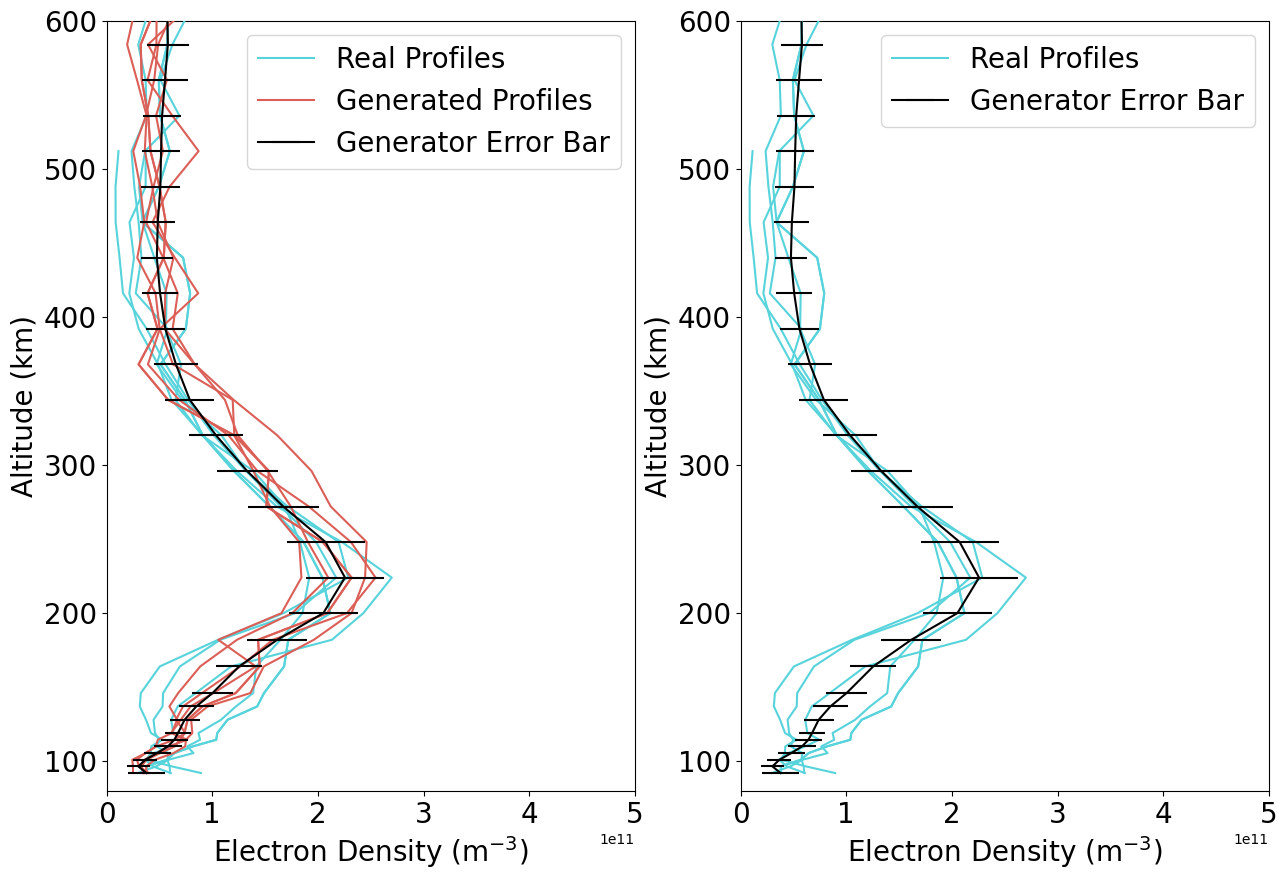

In [10]:
idx = np.argwhere((np.abs(drivers[:, const.dr_cols['MLT']]-12.)<1.) & (drivers[:,const.dr_cols['Ap']]<10.) & (drivers[:,const.dr_cols['F10.7']]<80.)).flatten()
avg_drivers = np.mean(drivers[idx,:], axis=0)[None,:]

gen_profiles = generate_bvs(avg_drivers.repeat(100, 0))
mean_profile = np.mean(gen_profiles, axis=0)
std_profile = np.std(gen_profiles, axis=0)

plt.style.use('default')
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
pal = sns.color_palette('hls', n_colors=2)
plt_idxs = np.random.choice(np.arange(len(gen_profiles)), replace=False, size=5)

ax[0].plot(bvs[idx[plt_idxs],:,0].T, const.altgrid[:30], c=pal[1], zorder=3)
ax[0].plot(bvs[idx[plt_idxs][-2:-1],:,0].T, const.altgrid[:30], c=pal[1], label='Real Profiles', zorder=3)
ax[1].plot(bvs[idx[plt_idxs],:,0].T, const.altgrid[:30], c=pal[1], zorder=3)
ax[1].plot(bvs[idx[plt_idxs][-2:-1],:,0].T, const.altgrid[:30], c=pal[1], label='Real Profiles', zorder=3)
# ax[0].set_title('Real Ne Profiles from PFISR')
ax[0].plot(gen_profiles[plt_idxs,:,0].T, const.altgrid[:30], c=pal[0],zorder=3)
ax[0].plot(gen_profiles[plt_idxs,:,0][-2:-1].T, const.altgrid[:30], c=pal[0], label='Generated Profiles',zorder=3)
# ax[0].set_title('Real vs Generated (Conditional)', fontsize=25)

for i in range(2):
    ax[i].errorbar(mean_profile[:,0], const.altgrid[:30], xerr=std_profile[:,0], color='black', label='Generator Error Bar', zorder=5)
    ax[i].set_xlim([0.,5.e11])
    ax[i].set_ylim([80.,600.])
    ax[i].set_xlabel(r'Electron Density (m$^{-3}$)', fontsize=20)
    ax[i].set_ylabel('Altitude (km)', fontsize=20)
    ax[i].legend(fontsize=20)
    ax[i].tick_params(labelsize=20)

plt.show()

The black profile in both plots is the mean and standard deviation of the sampled profiles from the GAN. They agree with the measured profiles, and contain information about the expected spread of the electron density at each altitude. The output of the GAN is **statistical**, and each individual generated profile is a sampled profile from the distribution but doesnot necessarily represent the "average" or "typical" conditions.


# Exploring the results

The above utilities are still being tested and developed. We expect to soon have the following included in the tutorial:
- Demonstrate how to evaluate BV/HFP GAN using the Hellinger Distance Metric
- Demonstration showing how to compare the histograms of generated data with historically observed data.

## Evaluating Model Performance

One way to evaluate the performance of our GAN model is to compare how similar the conditional background profile distributions of the real measurements are to the generated ones. To measure the similarity between two distributions we will use the Hellinger distance metric, which as the following formula:


$$H(p, q) = {\frac{1}{\sqrt2}}\sqrt{\sum \limits _{i=1}^ {k} (\sqrt{p_i} - \sqrt{q_i})^2}$$

The hellinger distance metric can score anywhere between 0 (very similar) to 1 (very different). We can perform this calculation by calling the `hellinger_distance_bv` function. This function will compute the Hellinger distance score for each background variable at each altitude using the conditional distributions derived from the inputted set of real and generated background profile samples. Along with inputting the samples we'll pass in the `alt_mask` so we don't end up using any invalid/nan samples in the calculation.


In [11]:
hel_dists = hellinger_scores_bv(bvs, G_bvs, mask=alt_mask)
print(f'Hellinger Distance Shape: {hel_dists.shape}')
print(f'Avg Hel Dist: {np.mean(hel_dists):.3f}')

Hellinger Distance Shape: (30, 12)
Avg Hel Dist: 0.059


The same process can be done with the HFP data. However, we can only compare samples that have present HFP waves before calling the scoring function we filter out any of the samples don't have a present wave using the `wave_mask`.

In [12]:
hfp_hel_dists = hellinger_scores_hfp(hfps[wave_mask[:, 0]], G_hfps[wave_mask[:, 0]])
print(f'HFP Hellinger Distance Shape: {hfp_hel_dists.shape}')
print(f'Avg Hel Dist: {np.mean(hfp_hel_dists):.3f}')

HFP Hellinger Distance Shape: (1, 8)
Avg Hel Dist: 0.101


## Comparing Real vs Generated

We can also visualize the performance of the BV GAN by plotting and comparing the distributions real and generated measurements for a particular altitude bin. For this example we'll look at the real and generated BV distributions for the 20th altitude bin.

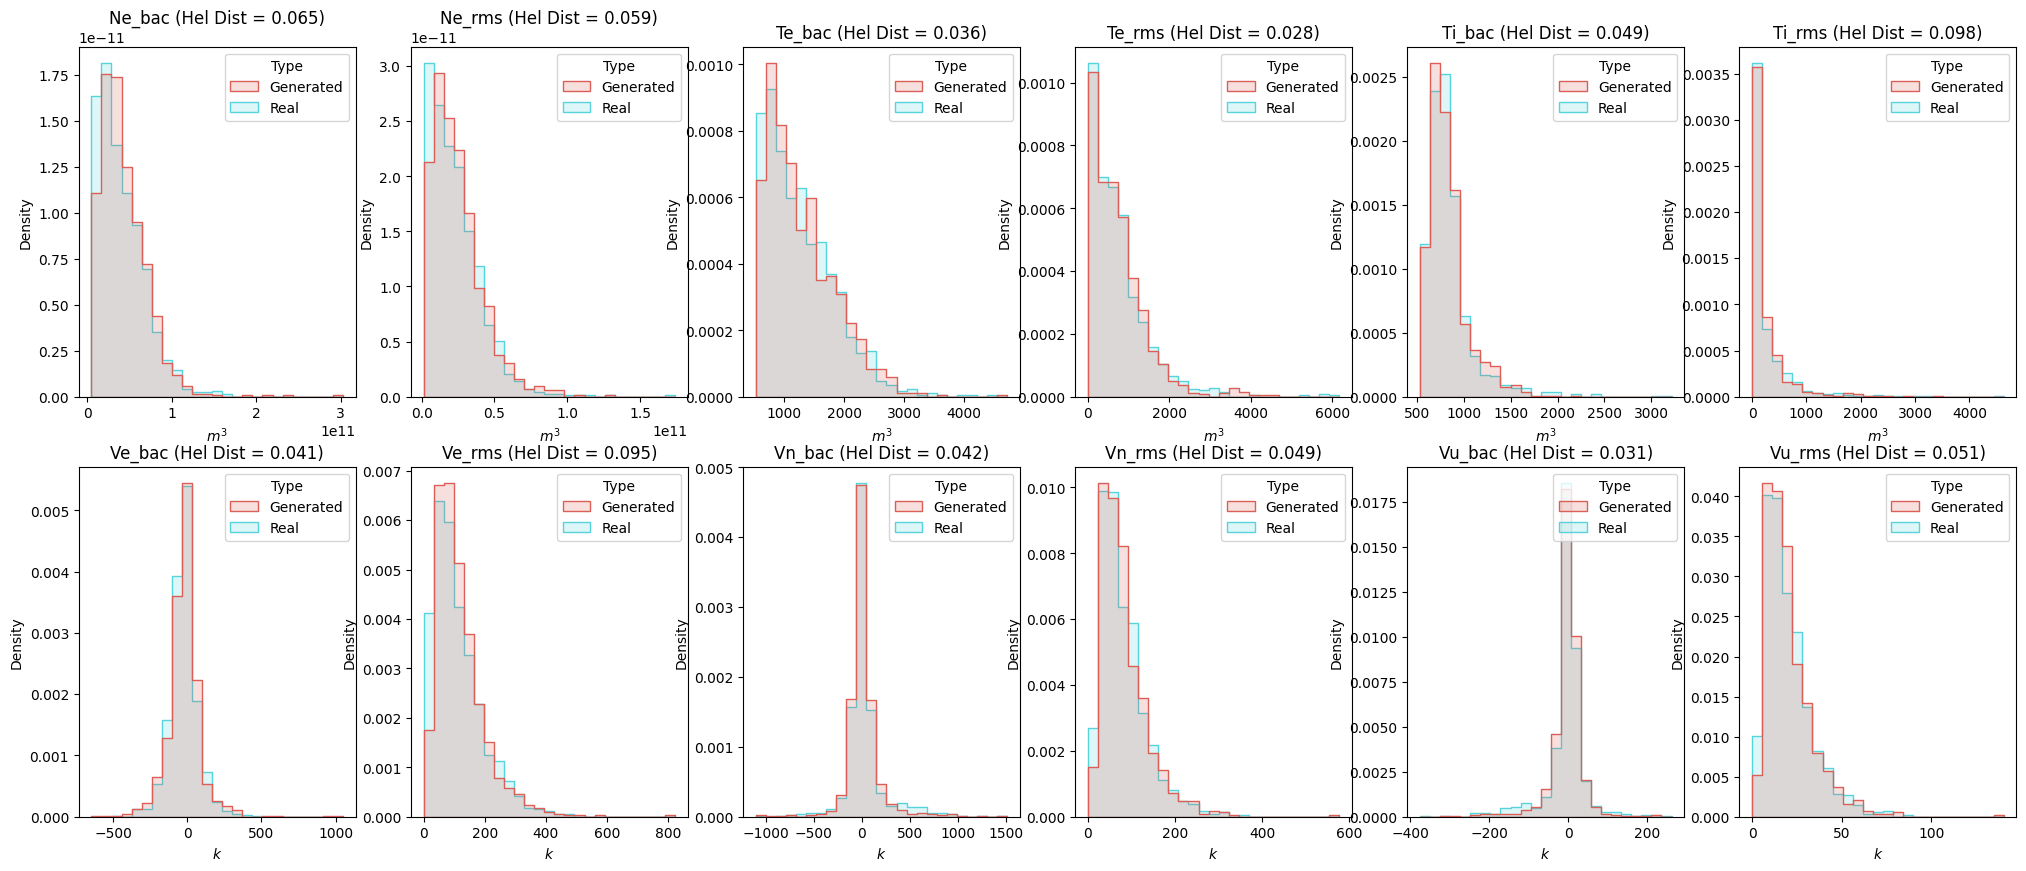

In [13]:
alt_bin = 20
real = bvs[alt_mask[:, alt_bin], alt_bin, :]
generated = G_bvs[alt_mask[:, alt_bin], alt_bin, :]

plt.style.use('default')
fig, ax = plt.subplots(2, 6, figsize=(25, 10))
ax = ax.flatten()
for i in range(len(ax)):
    x = np.hstack((real[... ,i].flatten(), generated[..., i].flatten()))
    hue = ['Real'] * len(real[... ,i].flatten()) + ['Generated'] * len(generated[..., i].flatten())
    data = pd.DataFrame({f'{const.bv_units[i]}': x, 'Type': hue})
    sns.histplot(data=data, x=f'{const.bv_units[i]}', hue='Type', ax=ax[i],
                 element='step', bins=25, legend=True, stat='density',
                 palette='hls', alpha=0.2, common_norm=False,
                 hue_order=['Generated', 'Real'])
    ax[i].set_title(f'{abcgan.constants.bv_names[i]} (Hel Dist = {hel_dists[alt_bin, i]:.3f})')
plt.show()

The same process can be done with the HFP data. However, before getting the Hellinger scores we first have to filter out any waves that are not present in the real hfps using the `wave_mask` and also filter out the generated waves that were predicted to not be present using the `Gb_mask` calculated earlier.

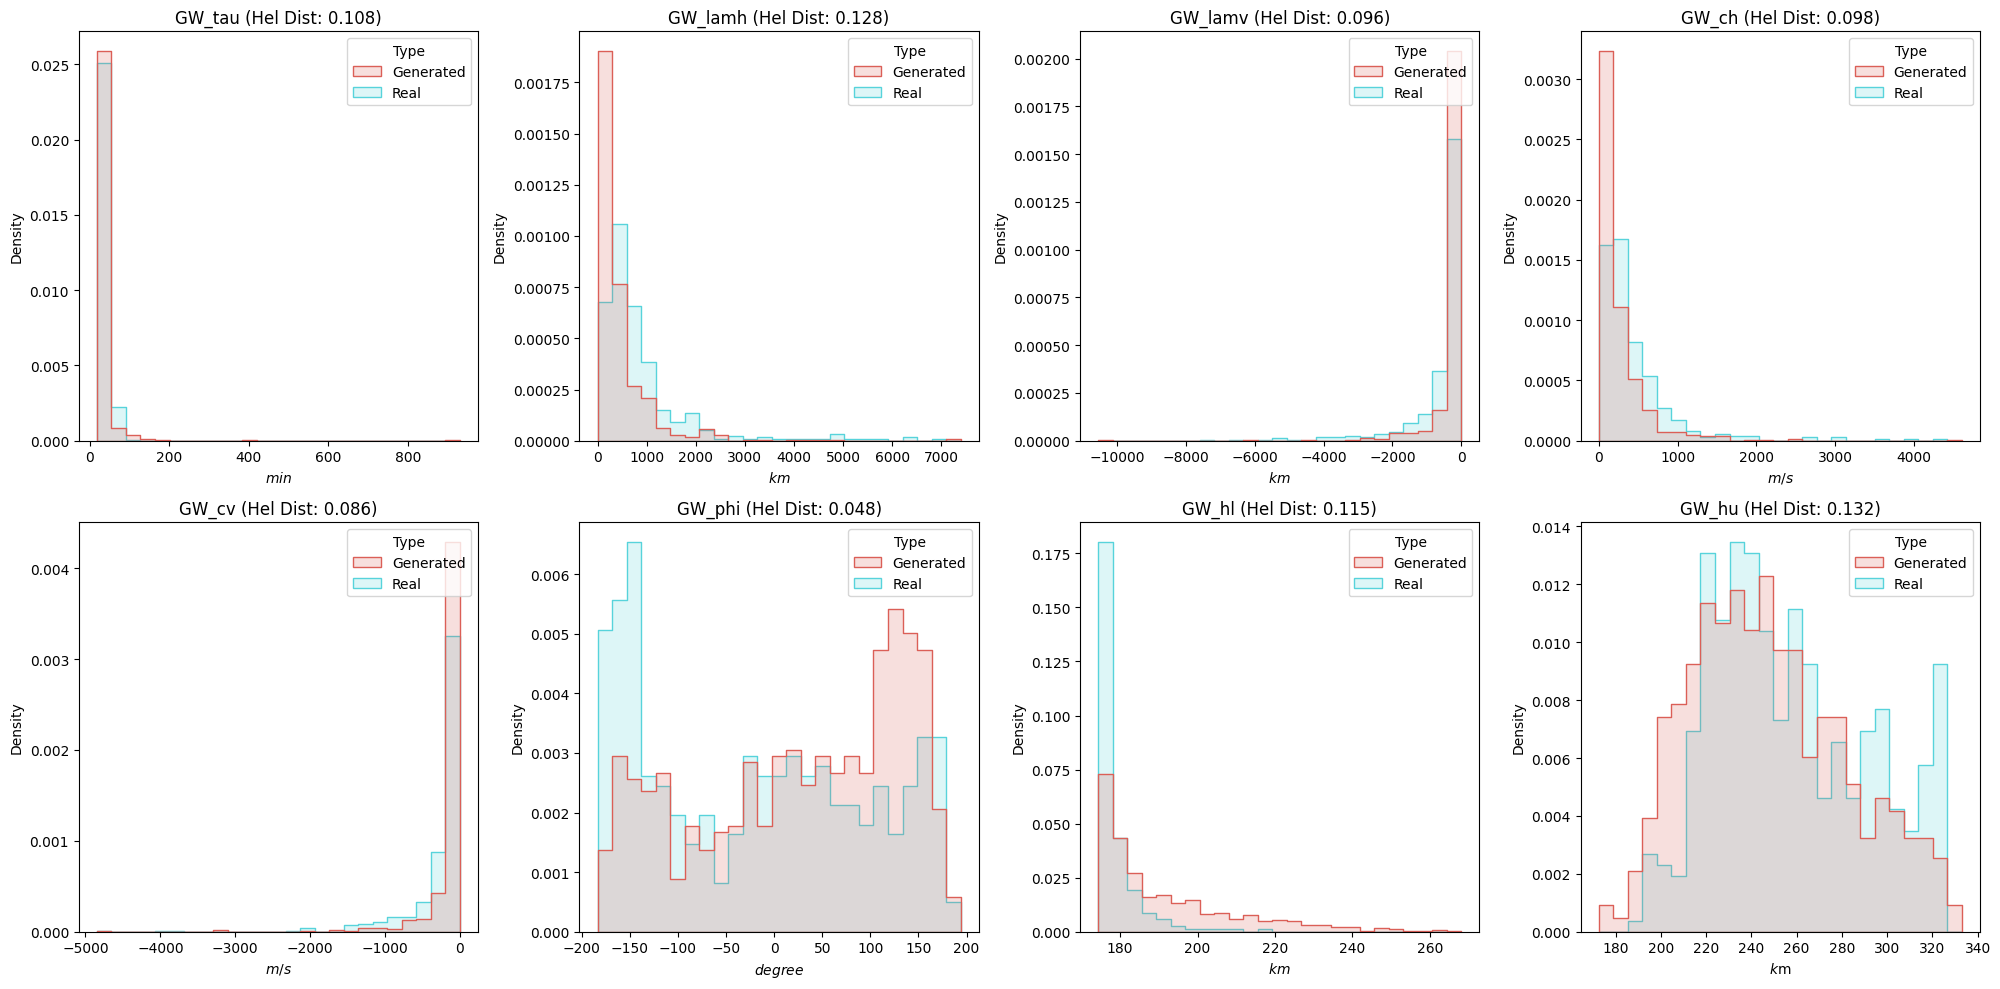

In [14]:
real = hfps[wave_mask, ...]
generated = G_hfps[Gb_mask, 0, ...]

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()
for i in range(len(ax)):
    x = np.hstack((real[... ,i].flatten(), generated[..., i].flatten()))
    hue = ['Real'] * len(real[... ,i].flatten()) + ['Generated'] * len(generated[..., i].flatten())
    data = pd.DataFrame({f'{const.hfp_units[i]}': x, 'Type': hue})
    sns.histplot(data=data, x=f'{const.hfp_units[i]}', hue='Type', ax=ax[i],
                 element='step', bins=25, legend=True, stat='density',
                 palette='hls', alpha=0.2, common_norm=False,
                 hue_order=['Generated', 'Real'])
    ax[i].set_title(f'{abcgan.constants.hfp_names[i]} (Hel Dist: {hfp_hel_dists[0, i]:.3f})')
plt.tight_layout()
plt.show()


# Using Previous Drivers To Estimate Current Drivers

In the situation that you don't have the current drivers available for predicting the background profile you can use the driver estimation model to predict the current driver features based on previous driver samples. Specifically the driver estimation model has been trained to predict a driver sample that occur 2 hours from the time of the input sample. We can simulate the situation in which we only have drivers sample from two hours ago by creating a new driver dataset containing of driver samples that occurred two hours from the actual background variable samples. Since the time difference between each sample isn't always the same in our dataset we have to calculate a mapping vector between current samples and previous samples from two hour ago. The `prev_driver_mask` function generates this mapping vector along with a mask for selecting the driver samples that have a previous driver sample from two hours ago, which we will use when evaluating the driver estimator.

In [15]:
curr_drivers, _, _, unix_time = load_h5_data(fname, n_samples=None)
prev_dr_map, dr_mask = prev_driver_mask(unix_time)
prev_drivers = curr_drivers[prev_dr_map]

We can now estimate the current driver samples from the previous by calling the `estimate_drivers` function. As you can see the estimated drivers are very similar to actual driver samples. Note that when using in realtime you can simply call the estimate driver function with two hour old driver samples to predict the current driver samples.

In [16]:
est_drivers = estimate_drivers(prev_drivers, model='dr_gan')
print(f'Original Driver Shape: {curr_drivers.shape}')
print(f'Estimated Driver Shape: {est_drivers.shape}')

Original Driver Shape: (5000, 29)
Estimated Driver Shape: (3398, 29)


We can look at how the estimated driver distribution compares to the actual driver samples. As you can see the estimated drivers are very similar to actual driver samples. From here you can pass the estimated driver samples into the background variable generator to estimate the current background profile.

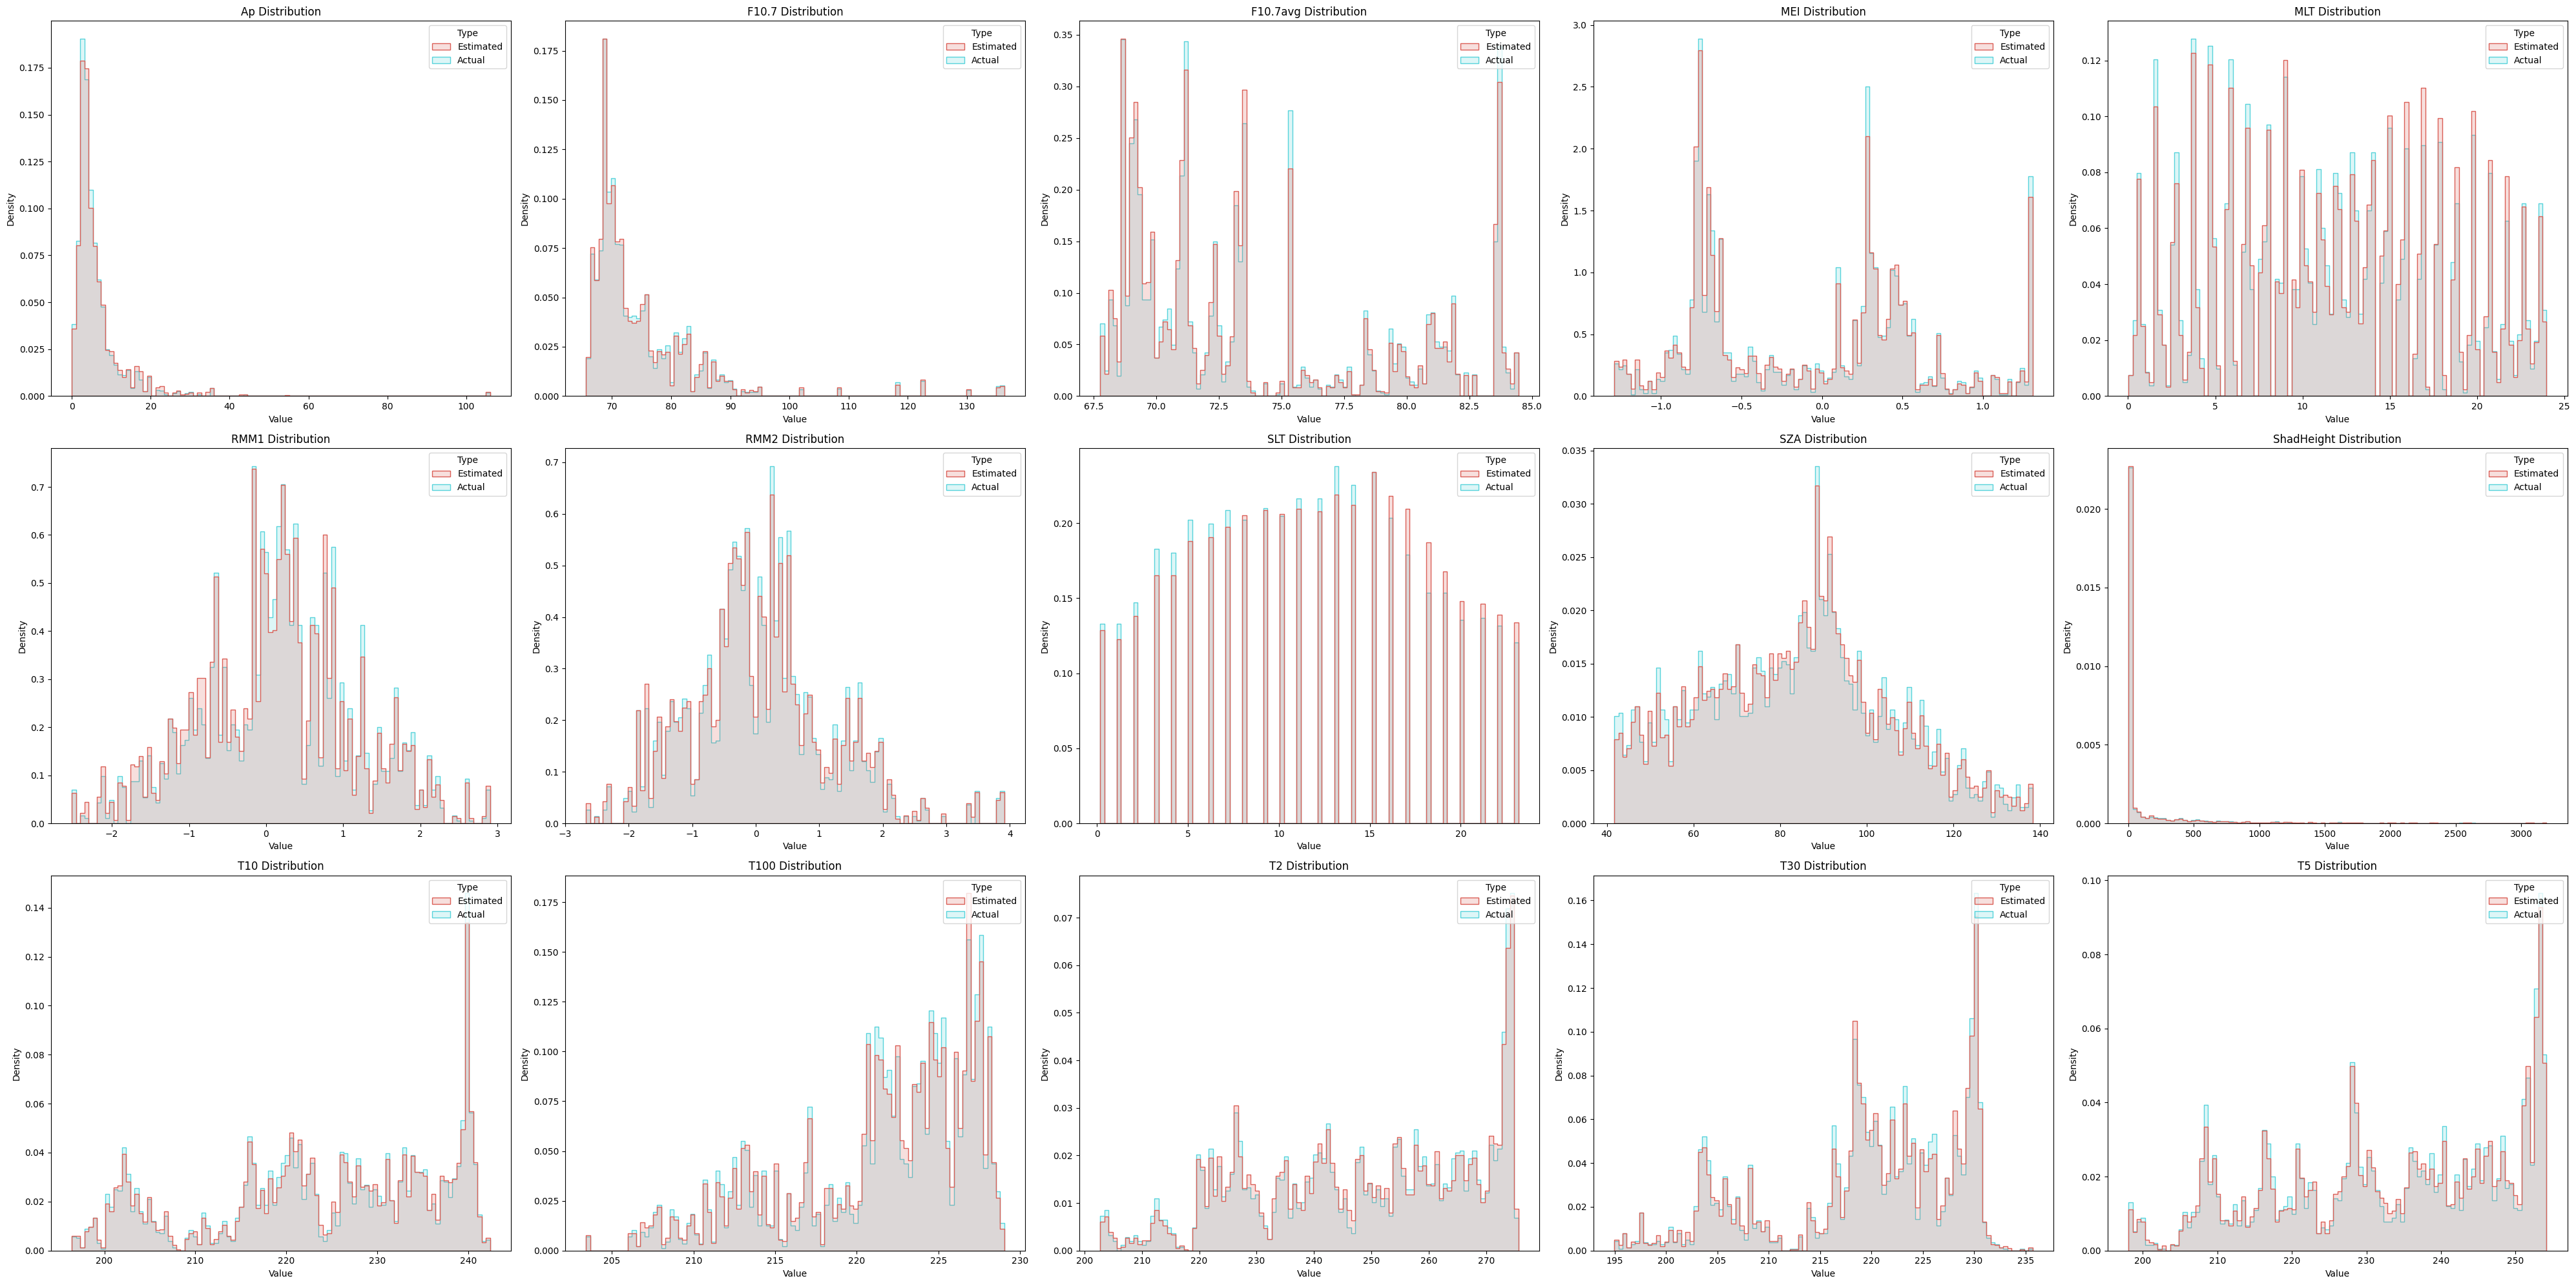

In [17]:
fig, ax = plt.subplots(3, 5, figsize=(40, 20))
ax = ax.flatten()
for i in range(len(ax)):
    x = np.hstack((curr_drivers[:, i], prev_drivers[:, i]))
    hue = ['Estimated'] * len(curr_drivers[:, i]) + ['Actual'] * len(prev_drivers[:, i])
    data = pd.DataFrame({'Value': x, 'Type': hue})
    sns.histplot(data=data, x='Value', hue='Type', ax=ax[i],
                 element='step', bins=100, legend=True, stat='density',
                 palette='hls', alpha=0.2,
                 hue_order=['Estimated', 'Actual'],
                 common_norm=False)
    ax[i].set_title(f'{const.driver_names[i]} Distribution')
plt.tight_layout()
plt.show()

# Detecting Anomalies with the GAN

GANs offer a convenient way to realize an anomaly detector. First, we apply the GAN to regenerate the statistical distribution of our dataset. Then, new data is compared to the generated statistical distribution using a 'log-probability' distance measure.

To compute the anomaly score, we apply a distance measure between new samples and a distribution of values generated by the GAN. To motivate our approach, first consider scalar data. For simplicity, assume our model is a random variable, so repeated calls to the GAN will generate a normal distribution centered around a mean value $\mu$ with standard deviation $\sigma$, then we may estimate the probability $p$ of a new signal $x$ comes from the distribution as.

$$p(x) = \frac{exp(-\frac{1}{2}{\delta}^2)}{\sigma \sqrt{2 \pi}}.$$

We define a dimensionless variable $\delta = (x-\mu)/\sigma $. As the distance to the new point $\delta$ increases, the exponential may underflow, or be too small to evaluate exactly. To fix underflow, we compute the log of the exponent to estimate an anomaly score, $A$.

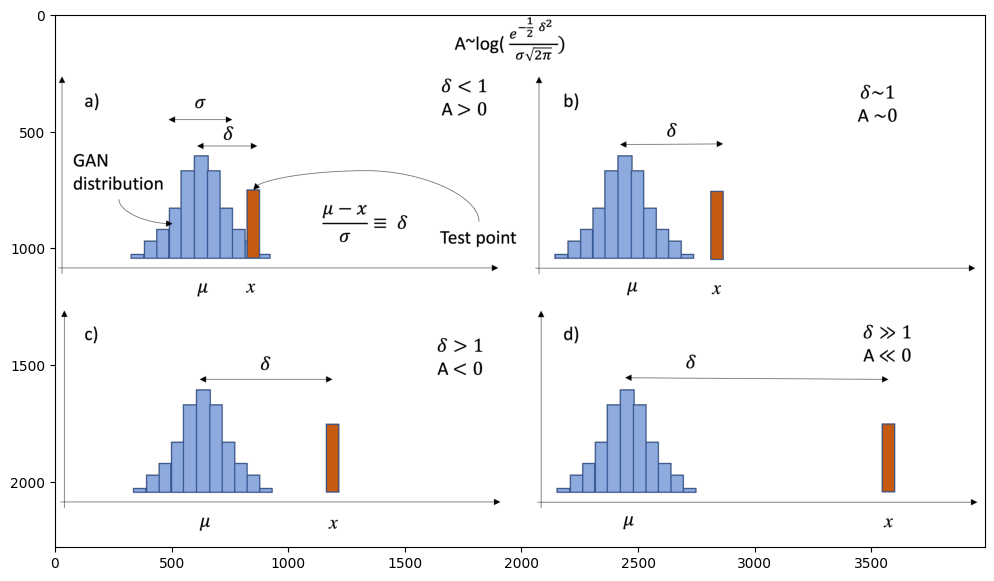

In [18]:
img = mpimg.imread('img/anom-normal.png')
plt.figure(figsize = (12,12))
plt.imshow(img)

In plots $a)$ and $b)$, the distance to the distribution is small, so the exponential evaluates to value close to unity. However, as the new sample distance increases as in plots $ c)$ and $ d)$, the exponential evaluates to a very small number and is likely to underflow, meaning the value will be essentially zero.

## Multi-Dimensional Estimation

For our distance measure, we compute sum the exponential distances between the new sample point and 100 GAN-generated samples. The net effect is that we treat each new measurement as a random variable and the anomaly score tracks whether our new measurement is similar to any of the generated data points. If any of the GAN points overlaps with the new data, then it drives the anomaly score to a positive number. However, if none of the generated points lies near the sample data, then the anomaly score returns a negative number. To capture distances within the joint distribution, we compute the L2 norm between the N-dimensional sample and each generated data point, assuming a standard deviation $\sigma_N$ computed from the geometric mean of all $N$ features $\sigma_N = 2* \sqrt[N]{(\prod \sigma_i)}/M$. Note the standard deviation was divided by the number of generated samples $M$ = 10,000. Finally, we compute the anomaly score $A$ for a given sample $x$ with numpy's built-in $logsumexp$ function, which is simply a numerically stable form of

$$A(x) = log(\sum_{i}e^{-1/2 {||\hat{x}-\hat{\mu}||}^2/\sigma_N^2}).$$


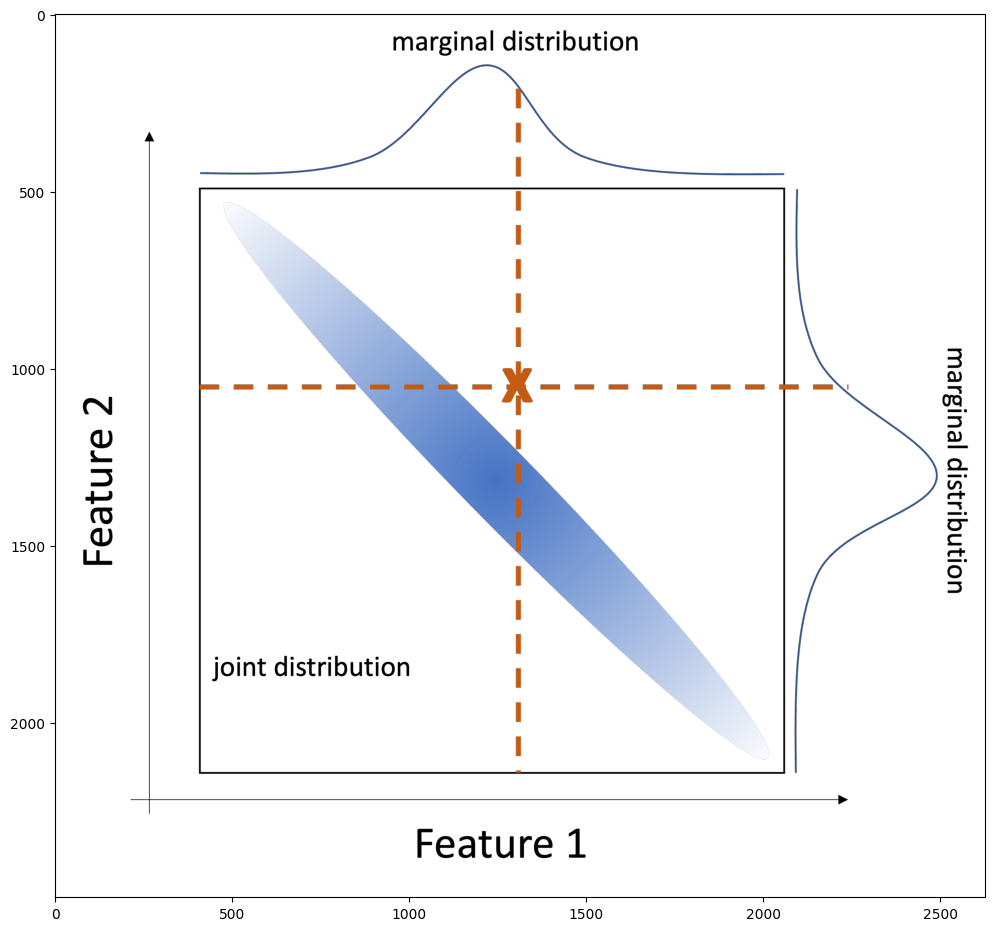

In [19]:
img = mpimg.imread('img/marginal_vs_joint.png')
plt.figure(figsize = (12,12))
plt.imshow(img)

## BV Anomaly Example

Fist we have to Generate sampled fake data, which we can do using the `generate_mutli_bv` function. For this example we are going to generate 500 background profiles for a random driver sample to use in our anomaly estimation. Note that this may take minute to compute because we are generating 500 background profiles. You can lower `n_repeat` to speed up the process, but the fewer samples you generate the more inconsistent the anomaly detection results will be.

In [20]:
sample_idx = np.random.choice(np.arange(len(drivers))[wave_mask[:, 0]], size=[1])
n_repeat = 500
G_sampled_bvs = generate_multi_bv(drivers[sample_idx, ...], n_repeat=n_repeat)

print(f"G_bvs Shape = {G_sampled_bvs.shape}")
print(f"N Driver Samples = {G_sampled_bvs.shape[0]}")
print(f"N Background Profiles = {G_sampled_bvs.shape[1]}")
print(f"N alt Bins = {G_sampled_bvs.shape[2]}")
print(f"N Background Variables = {G_sampled_bvs.shape[3]}")

Generating BV Samples: 100%|██████████| 1/1 [00:13<00:00, 13.61s/it]

G_bvs Shape = (1, 500, 30, 12)
N Driver Samples = 1
N Background Profiles = 500
N alt Bins = 30
N Background Variables = 12


With our 500 generate background profile samples we can calculate anomaly scores for our randomly selected driver under question using the `anomaly_score_bv` function. This function will produce anomaly scores for every Background feature at each alt bin by using the marginal distributions of a background profile or produce a single anomaly score for each altitude bin by using the joint distributions of a background profile. You can declare which method to use by setting the `method` argument to either "marginal" or "joint".

In [21]:
marginal_anomalies = anomaly_score_bv(bvs[sample_idx, ...], G_sampled_bvs, method='marginal', alpha=2.0)
print(f'Shape of Marginal Method Anomalies: {marginal_anomalies.shape}, Avg Score: {np.nanmean(marginal_anomalies):.2f}')

joint_anomalies = anomaly_score_bv(bvs[sample_idx, ...], G_sampled_bvs, method='joint', alpha=2.0)
print(f'Shape of Joint Method Anomalies: {joint_anomalies.shape}, Avg Score {np.nanmean(joint_anomalies):.2f}')

Shape of Marginal Method Anomalies: (1, 30, 12), Avg Score: 4.10
Shape of Joint Method Anomalies: (1, 30), Avg Score 0.93


We can visualize the anomalies scores by plotting the generated background profiles along side the real background profile measurements. The real background profile will be colored based on its anomaly score so we can visualize how the background measurements compare to the calculated anomaly scores across all the altitudes. Remember a high anomaly score means that the sample was found to be normal vs low score means the sample was found to be irregular.

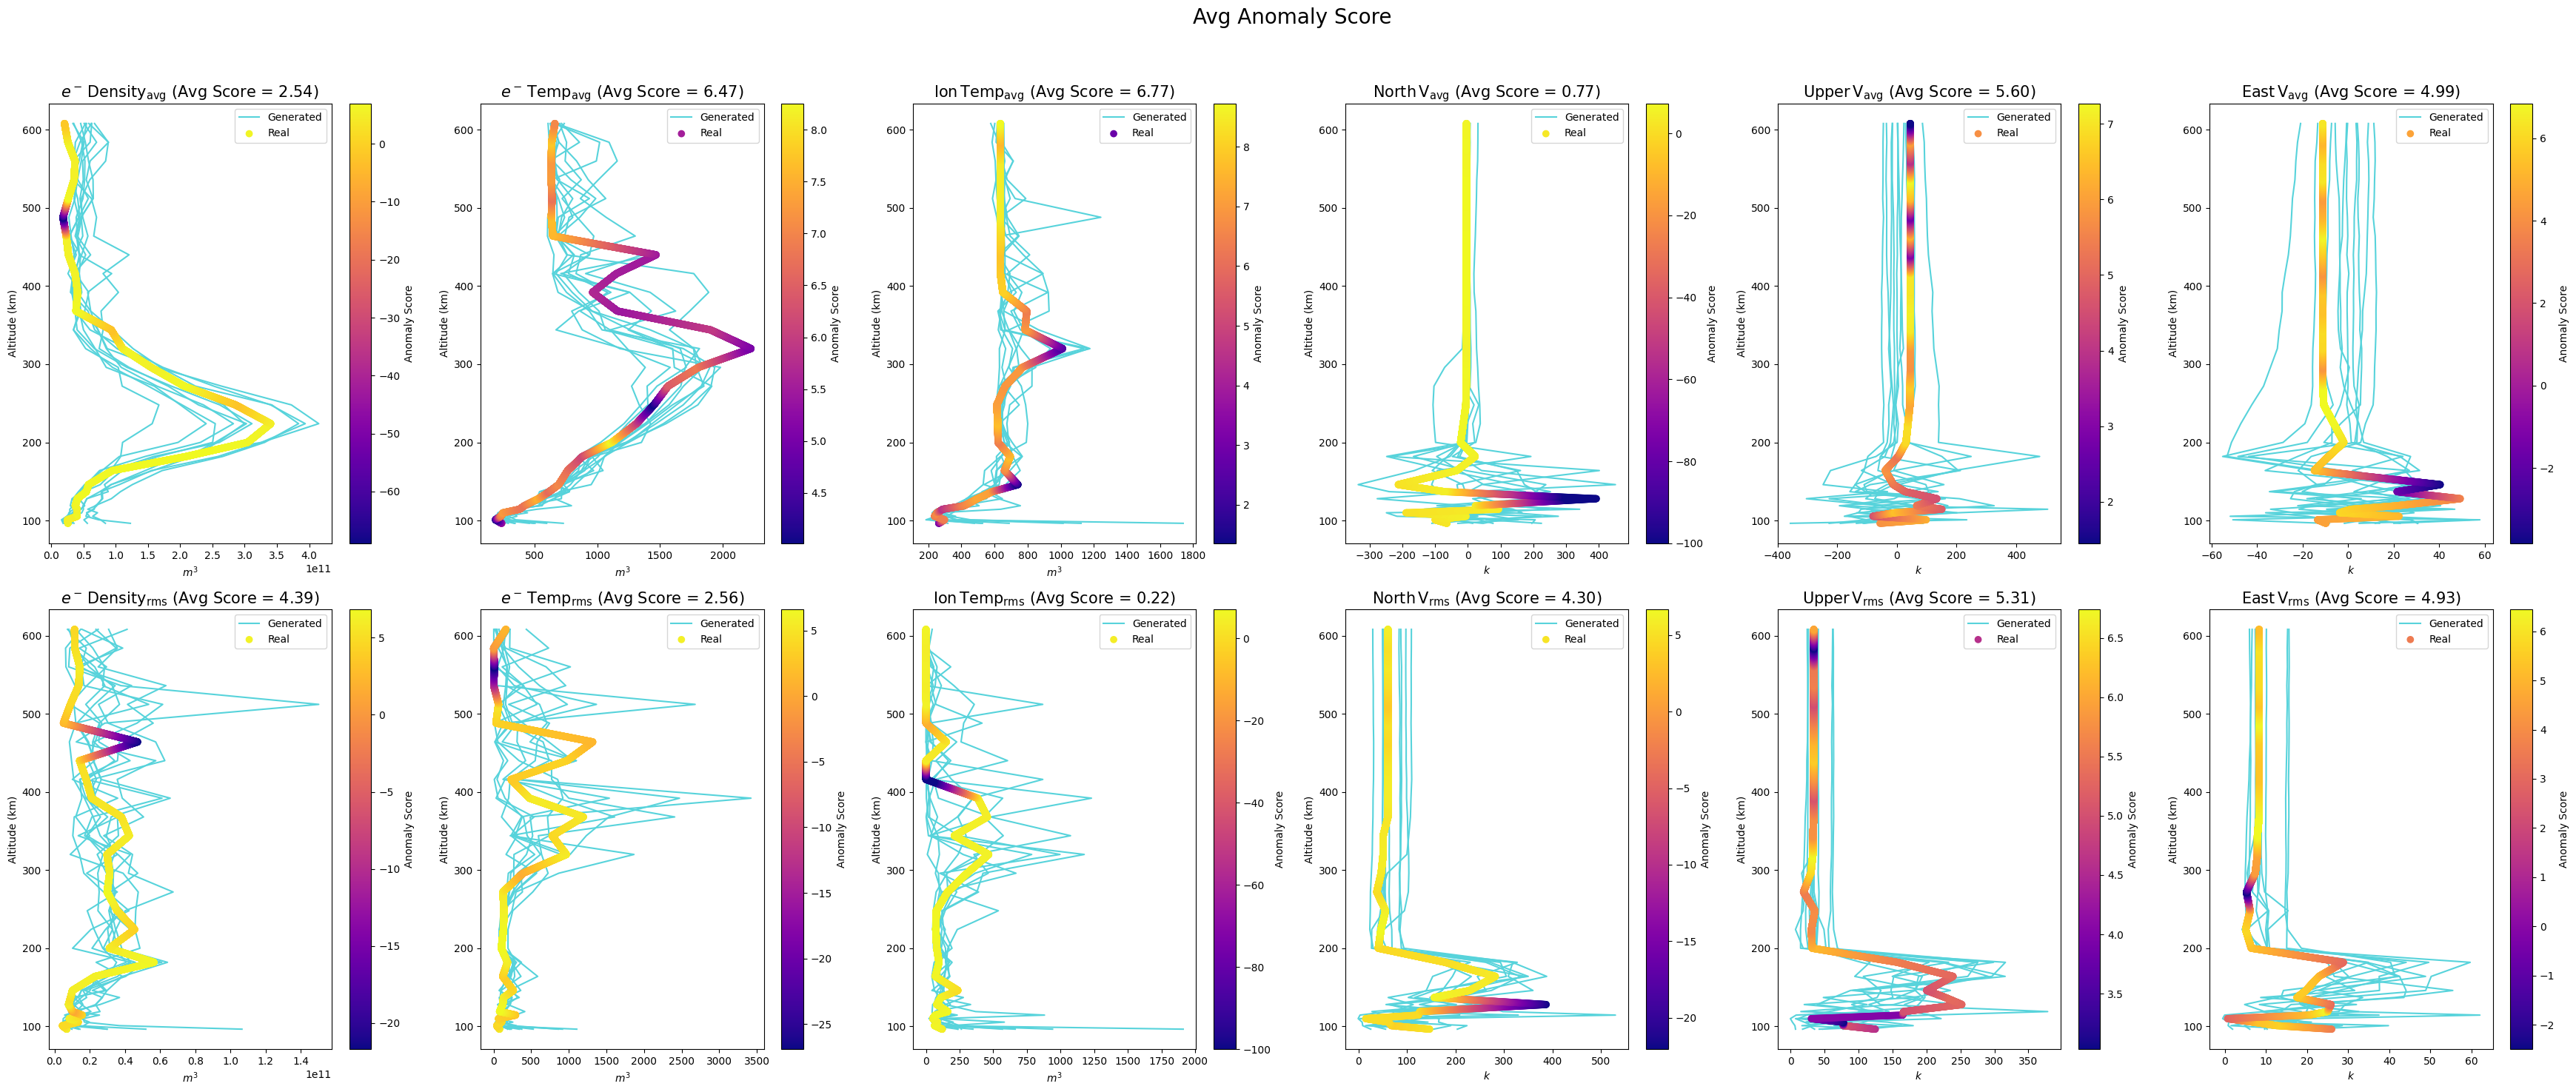

In [22]:
plt.style.use('default')
fig, ax = plt.subplots(2, 6, figsize=(35, 15))
pal = sns.color_palette('hls', n_colors=2)
alt_grid = const.altgrid[1:const.max_alt]
for i in range(6):
    for j in range(2):
        bv_index = 2*i + j
        for k in range(9):
            ax[j, i].plot(G_sampled_bvs[0, k, 1:, bv_index], alt_grid, color=pal[1])
        ax[j, i].plot(G_sampled_bvs[0, -1, 1:, bv_index], alt_grid, label='Generated', color=pal[1])
        # ax[j, i].plot(bvs[sample_idx[0], :, bv_index], alt_grid, label='Real', color=pal[0],)
        alts_interp = np.linspace(const.altgrid[1], const.altgrid[const.max_alt - 1], 10000)
        bvs_interp = np.interp(alts_interp, xp=const.altgrid[1:const.max_alt], fp=bvs[sample_idx[0], 1:, bv_index],)
        anom_interp = np.interp(alts_interp, xp=const.altgrid[1:const.max_alt], fp=marginal_anomalies[0, 1:, bv_index],)
        im = ax[j, i].scatter(bvs_interp, alts_interp, label='Real', c=anom_interp, cmap='plasma', zorder=11,
                              vmin=max(np.nanmin(marginal_anomalies[0, 1:, bv_index]), -100), vmax=np.nanmax(marginal_anomalies[0, 1:, bv_index]))
        ax[j, i].legend()
        ax[j, i].set_xlabel(const.bv_units[bv_index], fontsize=10)
        ax[j, i].set_ylabel('Altitude (km)', fontsize=10)
        ax[j, i].set_xlabel(const.bv_units[bv_index], fontsize=10)
        ax[j, i].set_title(f'{const.bv_full_names[bv_index]} '
                           f'(Avg Score = {np.nanmean(marginal_anomalies[0, 1:, bv_index]):.2f})',
                           fontsize=15)
        fig.colorbar(im, ax=ax[j, i], label='Anomaly Score')

plt.suptitle(f'Avg Anomaly Score', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



## HFP Anomaly Example

When looking at detecting anomalies in the HFP data we can compute an anomaly score using generated HFPs that were either conditioned with real background profile measurements or measurements generated from the BV GAN. To get anomaly scores using HFPs conditioned on real background profiles we first call the `multi_generate` function with the real BV measurements passed in as an argument.

In [23]:
G_sampled_hfps, G_sampled_b = generate_multi_hfp(drivers[sample_idx, ...], bvs=bvs[sample_idx, ...], n_repeat=n_repeat)
print(f"G_hfps Shape = {G_sampled_hfps.shape}")

Generating HFP Samples: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

G_hfps Shape = (1, 500, 1, 8)


Once we have the sampled HFP waves that were conditioned on real background measurements we pass them into the `anomaly_score_hfp` function. Again we can perform marginal based anomaly estimation, which will return an anomaly score for each wave parameters in a sample, or a joint based anomaly estimation, which will return a single anomaly score for each sample.

In [24]:
anomalies_hfp = anomaly_score_hfp(hfps[sample_idx, :], G_sampled_hfps, method='marginal', alpha=2.0)
print(f'Shape of Anomalies: {anomalies_hfp.shape}')
print([f'{const.hfp_names[i]}: {anomalies_hfp[0, 0, i]:.2f}' for i in range(const.n_hfp)])

Shape of Anomalies: (1, 1, 8)
['GW_tau: 3.08', 'GW_lamh: 5.61', 'GW_lamv: 6.78', 'GW_ch: 5.77', 'GW_cv: 6.12', 'GW_phi: 6.67', 'GW_hl: 6.61', 'GW_hu: -13.87']


In [25]:
nd_anomalies_hfp = anomaly_score_hfp(hfps[sample_idx, :], G_sampled_hfps, method='joint', alpha=2.0)
print(f'Shape of N-Dim Anomalies: {nd_anomalies_hfp.shape}, N-Dim Anomaly Score: {nd_anomalies_hfp.item():.2f}')

Shape of N-Dim Anomalies: (1, 1), N-Dim Anomaly Score: 1.83


On the other hand we can also compute anomaly scores using HFPs that were not conditioned with real background profile measurements. This will require generating the HFPs again using the `multi_generate` function, but this time we won't pass in any real background profile measurements. Again we can use the `anomaly_score_hfp` function and pass in the non-conditioned generated HFPs

In [26]:
G_sampled_hfps, G_sampled_b = generate_multi_hfp(drivers[sample_idx, ...], bvs=G_bvs[sample_idx, ...], n_repeat=n_repeat)

Generating HFP Samples: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


In [27]:
anomalies_hfp = anomaly_score_hfp(hfps[sample_idx, :], G_sampled_hfps, method='marginal', alpha=1.0)
print(f'Non-Conditioned Scores')
print([f'{const.hfp_names[i]}: {anomalies_hfp[0, 0, i]:.2f}' for i in range(const.n_hfp)])

Non-Conditioned Scores
['GW_tau: -57.65', 'GW_lamh: -5.20', 'GW_lamv: 4.52', 'GW_ch: 5.64', 'GW_cv: 2.43', 'GW_phi: 5.51', 'GW_hl: 7.17', 'GW_hu: -1.00']


In [28]:
nd_anomalies_hfp = anomaly_score_hfp(hfps[sample_idx, :], G_sampled_hfps, method='joint', alpha=1.0)
print(f'Non-Conditioned N-Dim Anomaly Score: {nd_anomalies_hfp.item():.2f}')

Non-Conditioned N-Dim Anomaly Score: 0.58


## Comparing Real Data Vs Fake Data

We can also use the anomaly score as a metric of how well a set of background profile or waves measurements fits the historically observed distributions that our model has learned to characterize. A simple experiment we can perform to verify this is to compare the real background profiles from our dataset to obviously fake background profile and wave measurements. For this example the obviously fake background and wave measurements are randomly selected from uniform distributions between known upper and lower bounds for each variable.

In [29]:
fake_hfp_data = np.zeros_like(G_sampled_hfps)
fake_bv_data = np.zeros_like(G_sampled_bvs)
for i in range(const.n_hfp_feat):
    fake_hfp_data[:, :, :, i] = np.random.uniform(low=const.hfp_thresholds[i, 0],
                                                  high=const.hfp_thresholds[i, 1], size=(1, n_repeat, 1))
for i in range(const.n_bv_feat):
    fake_bv_data[:, :, :, i] = np.random.uniform(low=const.bv_thresholds[i, 0],
                                                 high=const.bv_thresholds[i, 1], size=(1, n_repeat, const.max_alt))

We will compute the anomaly scores of the fake data we just randomly generated and compare them to the anomaly scores generated in the previous example. We expect that the anomaly scores of the fake data will be significantly lower than the anomaly scores we generated using background profiles generated from our model, which is exactly what we see when we compare the scores below. Note we are using `np.nanmean()` to get an overall score because some samples have missing wave and/or background profile measurements which would produce nans in those positions as expected.

In [30]:
real_anomaly_scores_bv = anomaly_score_bv(bvs[sample_idx, ...], G_sampled_bvs, alpha=1.0, method='joint')
fake_anomaly_scores_bv = anomaly_score_bv(bvs[sample_idx, ...], fake_bv_data, alpha=1.0, method='joint')

print(f'Real Background Measurements Anomaly Score: {np.nanmean(real_anomaly_scores_bv)}')
print(f'Fake Background Measurements Anomaly Score: {np.nanmean(fake_anomaly_scores_bv)}')

Real Background Measurements Anomaly Score: -4.068878002833192
Fake Background Measurements Anomaly Score: -135.8449236056502


We can do the same for the HFPs Data

In [31]:
real_anomaly_scores_hfp = anomaly_score_hfp(hfps[sample_idx, ...], G_sampled_hfps, alpha=1.0, method='joint')
fake_anomaly_scores_hfp = anomaly_score_hfp(hfps[sample_idx, ...], fake_hfp_data, alpha=1.0, method='joint')

print(f'Real HFP Measurements Anomaly Score: {np.nanmean(real_anomaly_scores_hfp)}')
print(f'Fake HFP Measurements Anomaly Score: {np.nanmean(fake_anomaly_scores_hfp)}')


Real HFP Measurements Anomaly Score: 0.5806393550076
Fake HFP Measurements Anomaly Score: -36.216158096763955


# Attention Map Analysis

Both BV and HFP GANs are conditioned using a transformer model, which makes use an attention mechanism to weigh the importance of background measurements from subsequent altitude bins. The transformer is split into an encoder, which takes in background variables and produces the conditional inputs for the BV Generator and a decoder which takes in the encoder outputs and produces conditional inputs for the HPF Generator. The encoder has a self-attention mechanism that looks at previous altitude measurements to help make predictions for higher altitude bins. The self-attention mechanism learns to weigh subsequent measurements differently allowing it to pay more attention to inputs that help the encoder produce better conditional inputs for the BV Generator. Like the encoder the decoder also has an attention mechanism that learns to weigh the importance of outputs from the encoder at specific altitude bins.

These attention weights shows what our models learned to pay attention to in order background profiles and waves under specific conditions and may display patterns that show some underlying physics the has model learned in order to generate BV profiles and HFP waves. We can view attention maps for the encoder and decoder given a set of inputs (Drivers/BVs) using the `collect_bv_attn_map` and  `collect_hfp_attn_map` functions. The BV self-attention map is collected from the encoder and has the output shape of (n_alt x n_alt) and the HFP attention map is collected from the decoder and has th output shape of (1 x n_alt).


In [32]:
attn_map_bv = collect_bv_attn_map(drivers, bvs)
attn_map_hfp = collect_hfp_attn_map(drivers, bvs)

print(f'Attention Map Shape: {attn_map_bv.shape}')
print(f'{attn_map_bv.shape} Samples')
print(f'{attn_map_bv.shape[1]} x {attn_map_bv.shape[2]} Self-Attention Weights Per Altitude\n')
print(f'HFP Attention Map Shape: {attn_map_hfp.shape}')
print(f'{attn_map_hfp.shape} Samples')
print(f'{attn_map_hfp.shape[1]} x {attn_map_hfp.shape[2]} Attention Weights Per Altitude')

Attention Map Shape: (1000, 30, 30)
(1000, 30, 30) Samples
30 x 30 Self-Attention Weights Per Altitude

HFP Attention Map Shape: (1000, 1, 30)
(1000, 1, 30) Samples
1 x 30 Attention Weights Per Altitude


## BV Self-Attention Map

We can visualize some general attention patterns learned by the model by plotting the maps averaged across all the sample. Since we generate the BV profile layer by layer from bottom to top we have to mask the upper values to ensure that the encoder is only allowed to use values from subsequent lower altitudes to predict values of the next altitude bin, which explains why the upper diagonal of the attention map has no attention. If we look at the BV's self-attention map from the encoder can still see that there are few distinct patterns. Some obvious ones include the consistently high attention along 0th altitude bin and the sudden decrease of attention that higher altitude layers place on measurements below the 13th altitude bin.


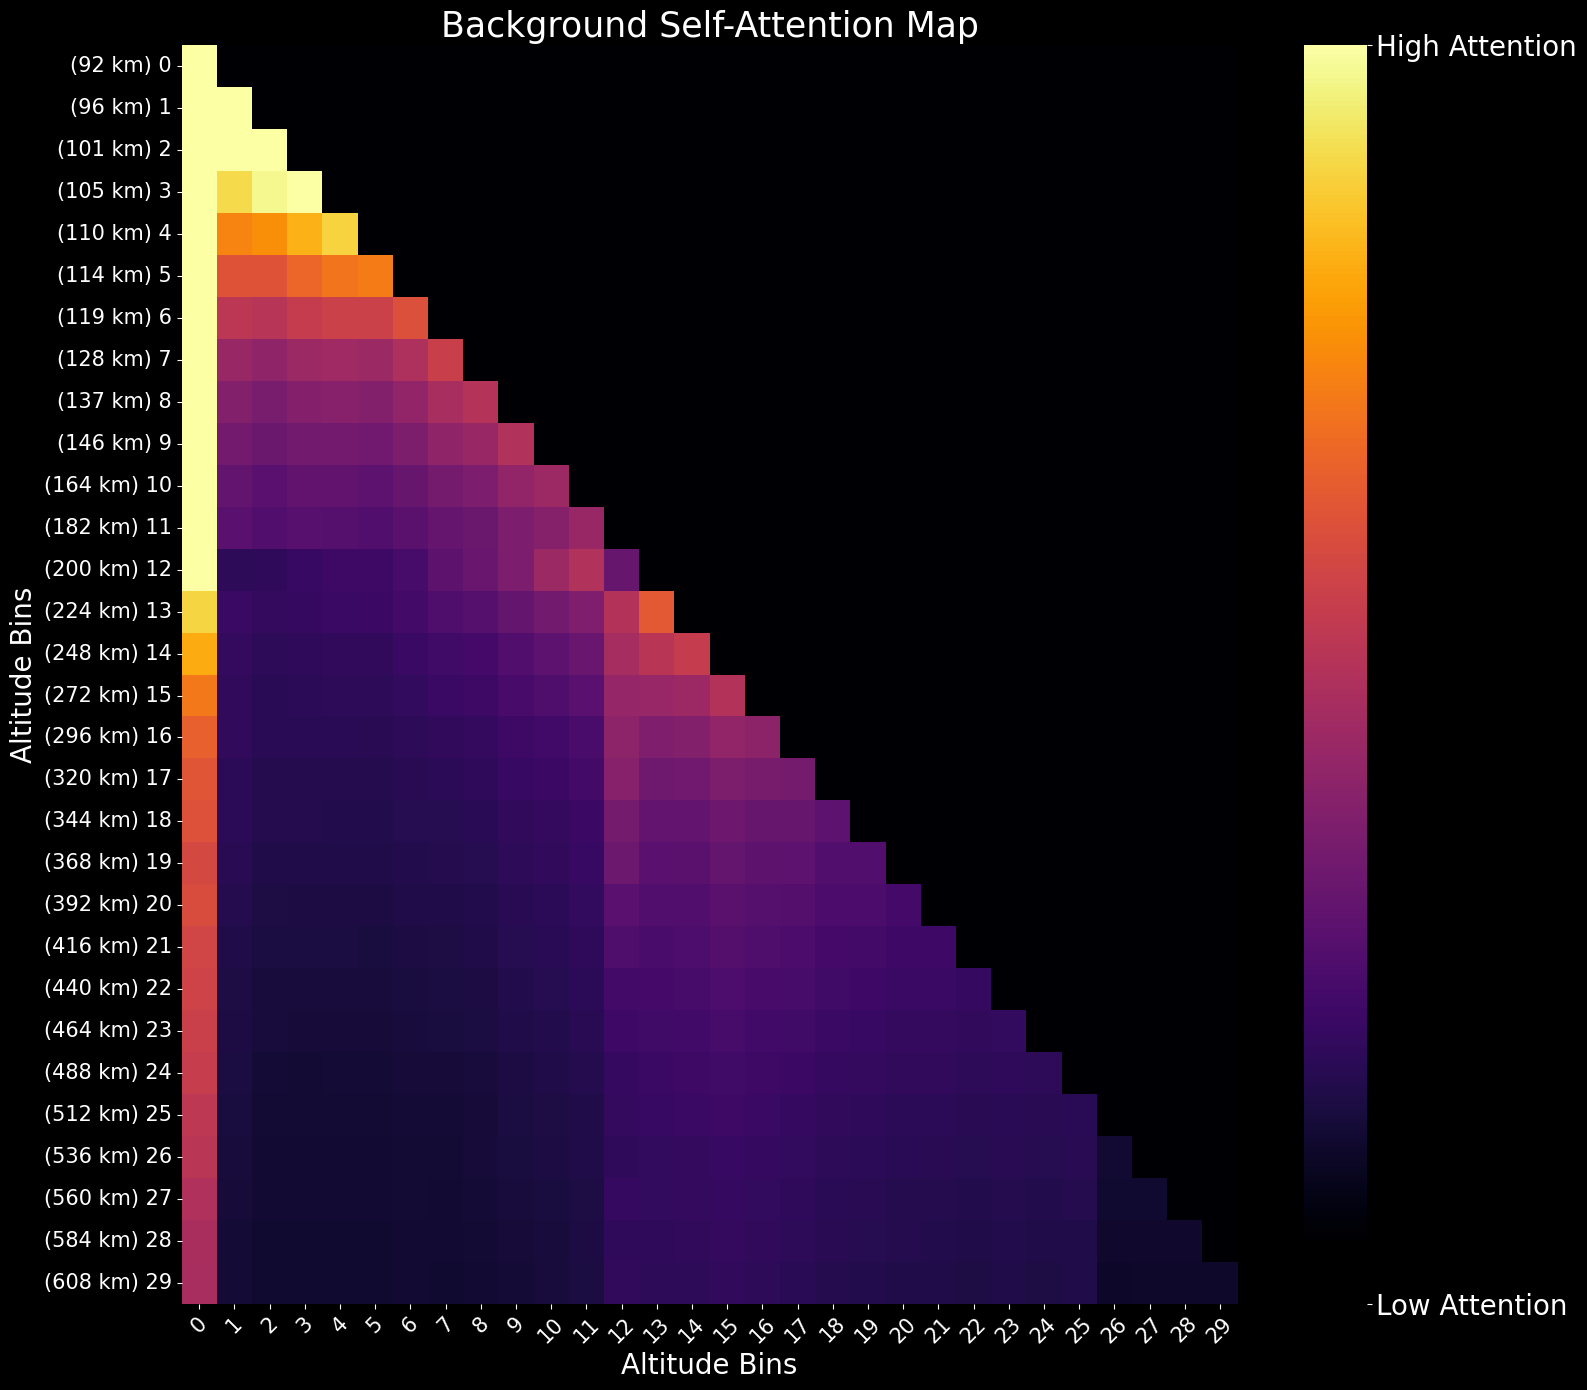

In [34]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(np.mean(attn_map_bv, axis=0),
            ax=ax, vmax=0.2, vmin=.01, cmap='inferno',
            yticklabels=[f'({const.altgrid[i].astype(int)} km) {i}' for i in range(const.max_alt)],)
cbar = ax.collections[0].colorbar
vmax, vmin = cbar.get_ticks()[0], cbar.get_ticks()[-1]
cbar.set_ticks(np.hstack((np.array([vmin]),np.array([vmax]))))
cbar.set_ticklabels(['High Attention'] + ['Low Attention'])
cbar.ax.tick_params(labelsize=20)
ax.tick_params(axis='x', labelsize=15, rotation=45)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel("Altitude Bins", fontsize=20)
ax.set_xlabel("Altitude Bins", fontsize=20)
ax.set_title("Background Self-Attention Map", fontsize=25)
plt.tight_layout()
plt.show()

## HFP Attention Map

We can also visualize the general attention pattern that decoder has on the inputs from the encoder. Since there is only a max of one wave per sample the attention map is really just an array, which we can see below. As you can see on average most of the attention is directed toward the values between altitude bin 11 - 18, which is makes sense because most of the HFP waves occur in that altitude region as shown by the histogram of upper and lower hfp bounds in the bottom figure.


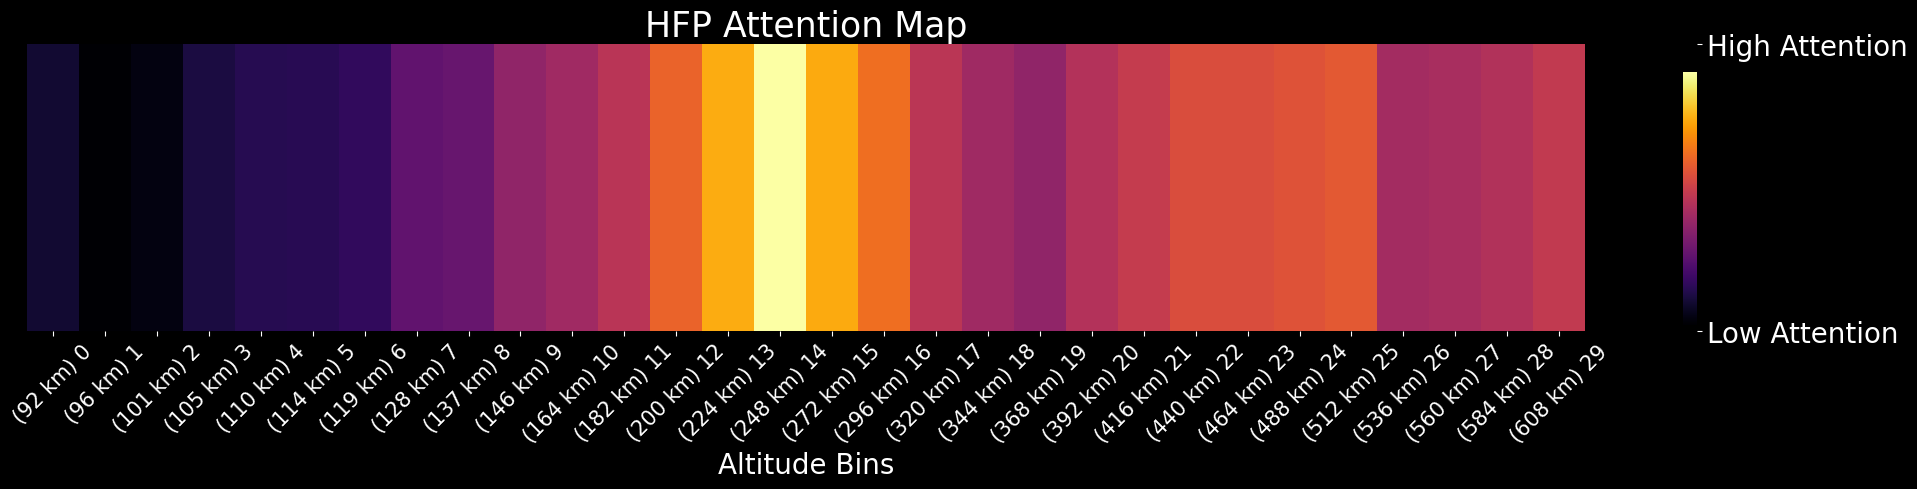

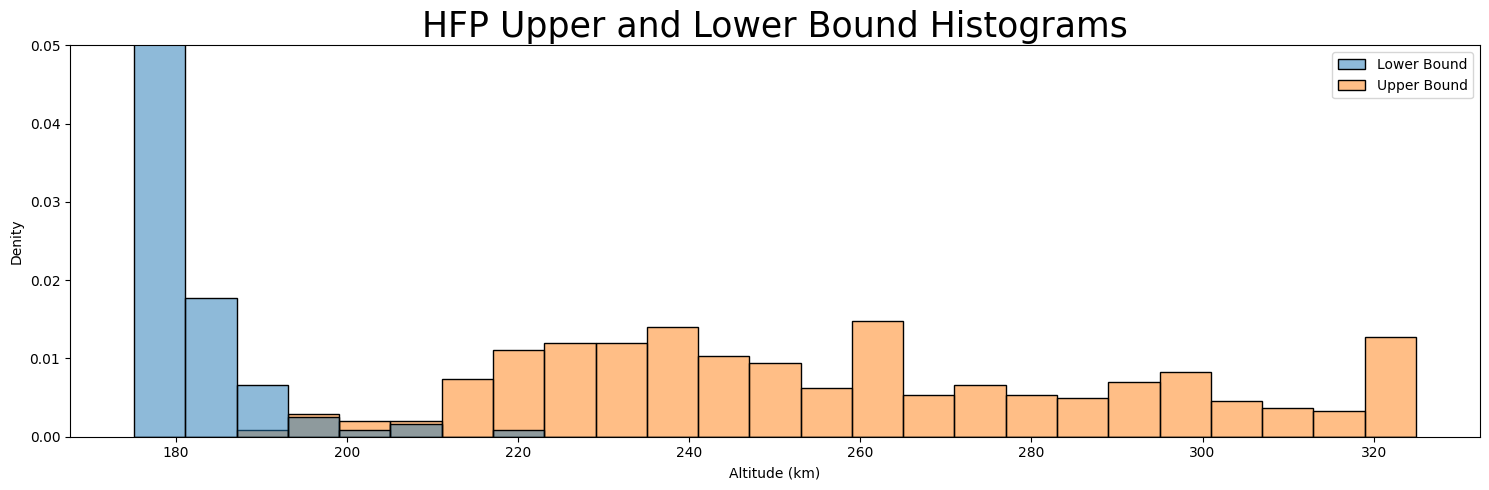

In [35]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(np.mean(attn_map_hfp, axis=0),
            ax=ax, cmap='inferno',
            xticklabels=[f'({const.altgrid[i].astype(int)} km) {i}' for i in range(const.max_alt)],)
cbar = ax.collections[0].colorbar
vmax, vmin = cbar.get_ticks()[0], cbar.get_ticks()[-1]
cbar.set_ticks(np.hstack((np.array([vmin]),np.array([vmax]))))
cbar.set_ticklabels(['High Attention'] + ['Low Attention'])
cbar.ax.tick_params(labelsize=20)
ax.set_yticks([])
ax.tick_params(axis='x', labelsize=15, rotation=45)
ax.set_xlabel("Altitude Bins", fontsize=20)
ax.set_title("HFP Attention Map", fontsize=25)
plt.tight_layout()
plt.show()

plt.style.use('default')
fig, ax = plt.subplots(figsize=(15, 5))
x = np.hstack((hfps[wave_mask, 6], hfps[wave_mask, 7]))
hue = ["Lower Bound"] * len(hfps[wave_mask, 6]) + ["Upper Bound"] * len(hfps[wave_mask, 7])
sns.histplot(x=np.hstack((hfps[wave_mask, 6], hfps[wave_mask, 7])),
             hue=["Lower Bound"] * len(hfps[wave_mask, 6]) + ["Upper Bound"] * len(hfps[wave_mask, 7]),
             ax=ax, stat='density', bins=25, common_norm=False)
ax.set_ylabel('Denity')
ax.set_ylim(0, 0.05)
ax.set_xlabel('Altitude (km)')
ax.set_title("HFP Upper and Lower Bound Histograms", fontsize=25)
plt.tight_layout()
plt.show()

# TEC Waves

ABC machine learning methods can be applied to characterize the atmosphere using alternative more globally available data sources. Specifically, this next section will show how we can use the same machine learning techniques to characterize atmospheric waves derived from TEC measurements collected from various GNSS stations near pokers. In theory, these TEC waves can be derived for any location which has nearby GNSS stations and later in the tutorial we will be showing how we trained our GAN to characterize the atmospheric over Mt Moses in Nevada using TEC wave data. Using the more globally available TEC data let us generalize our models to potentially work on a global scale, i.e. not just at Poker Flats.

The data team for ABC created two types of wTEC datasets. One dataset contains large scale transient ionospheric disturbances (LSTIDs), which contain waves that have longer periods between 3600-7200 seconds, and the other dataset contains medium scale transient ionospheric disturbances (MSTIDs), which contain waves with periods between 600-3600 seconds. We can load each dataset using the `load_wtec_h5` function. The wTEC data has the structure `(n_samples, n_wave_paramters)`.  We will first start off by loading the LSTIDs, which can be seen bellow. Like the previous data loader for the ISR the wTEC data loader will return the aligned drivers and unix timestamps. The data files used in this tutorial only contain a small subset of 5000 samples, which range from 2013-2014 shown in the plot below. The full dataset contains over 60,0000 wave samples and ranges from 2010-2020.




Drivers Shape: (5000, 29)
wTEC Shape: (5000, 18)
Unix Timestamp Shape: (5000,)
wtEC Wave Parameter Names: ['Amp_min', 'Amp_avg', 'Amp_max', 'Tau_min', 'Tau_avg', 'Tau_max', 'Lambda_min', 'Lambda_avg', 'Lambda_max', 'C1_min', 'C1_avg', 'C1_max', 'C2_min', 'C2_avg', 'C2_max', 'Phi_min', 'Phi_avg', 'Phi_max']


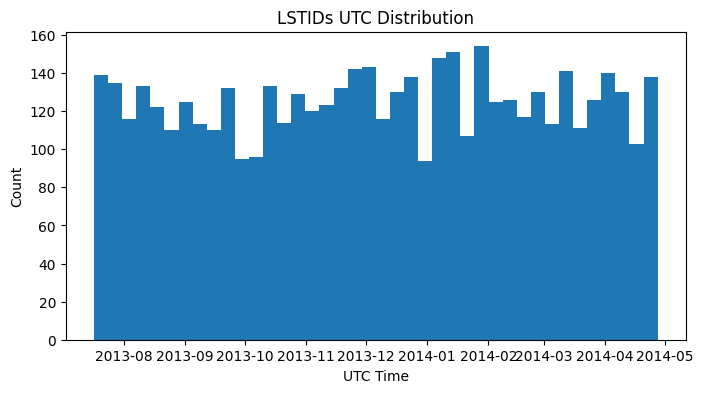

In [36]:
dataset_name = 'LSTIDs_Poker'
wtec_model = f'wtec_gan_{dataset_name}'
drivers, wtec_lstids, unix_time = load_wtec_h5(f'wtec_{dataset_name}.h5')
print(f'Drivers Shape: {drivers.shape}')
print(f'wTEC Shape: {wtec_lstids.shape}')
print(f'Unix Timestamp Shape: {unix_time.shape}')

print(f'wtEC Wave Parameter Names: {const.wtec_names}')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist([datetime.datetime.utcfromtimestamp(t) for t in unix_time], bins=40)
ax.set_ylabel("Count")
ax.set_xlabel('UTC Time')
ax.set_title('LSTIDs UTC Distribution')
plt.show()

## wTEC GAN (LSTIDs Poker Flats)
Like the HFP GAN, we created a similar more simplified wTEC GAN, which aims to generate historically accurate transient ionospheric disturbances, i.e. atmospheric waves, using a dataset we just loaded above. Unlike the HFP GAN the wTEC GAN is only conditioned on the external drivers when generating wave parameters and thus doesn't require an altitude based transformer for conditioning. To generate LSTID wTECs given a set of external driver you can call the `generate_wtec` function as shown below.

In [37]:
G_wtec_lstids = generate_wtec(drivers=drivers, dataset_name=dataset_name, wtec_model=wtec_model)
print(f'Generated wTEC LSTIDs Shape: {G_wtec_lstids.shape}')

Generating TEC Waves: 100%|██████████| 50/50 [00:00<00:00, 288.37it/s]

Generated wTEC LSTIDs Shape: (5000, 18)


We can evaluate the wTEC using the same Hellinger distance metric by calling the `hellinger_scores_wtec` function and passing in the real and generated samples as shown below. You can also see in the plot below how our generated distributions match the real distributions for each the wave parameters.

['Amp_min Dist: 0.063', 'Amp_avg Dist: 0.065', 'Amp_max Dist: 0.065', 'Tau_min Dist: 0.089', 'Tau_avg Dist: 0.084', 'Tau_max Dist: 0.120', 'Lambda_min Dist: 0.077', 'Lambda_avg Dist: 0.089', 'Lambda_max Dist: 0.113', 'C1_min Dist: 0.058', 'C1_avg Dist: 0.068', 'C1_max Dist: 0.064', 'C2_min Dist: 0.083', 'C2_avg Dist: 0.084', 'C2_max Dist: 0.082', 'Phi_min Dist: 0.107', 'Phi_avg Dist: 0.109', 'Phi_max Dist: 0.108']


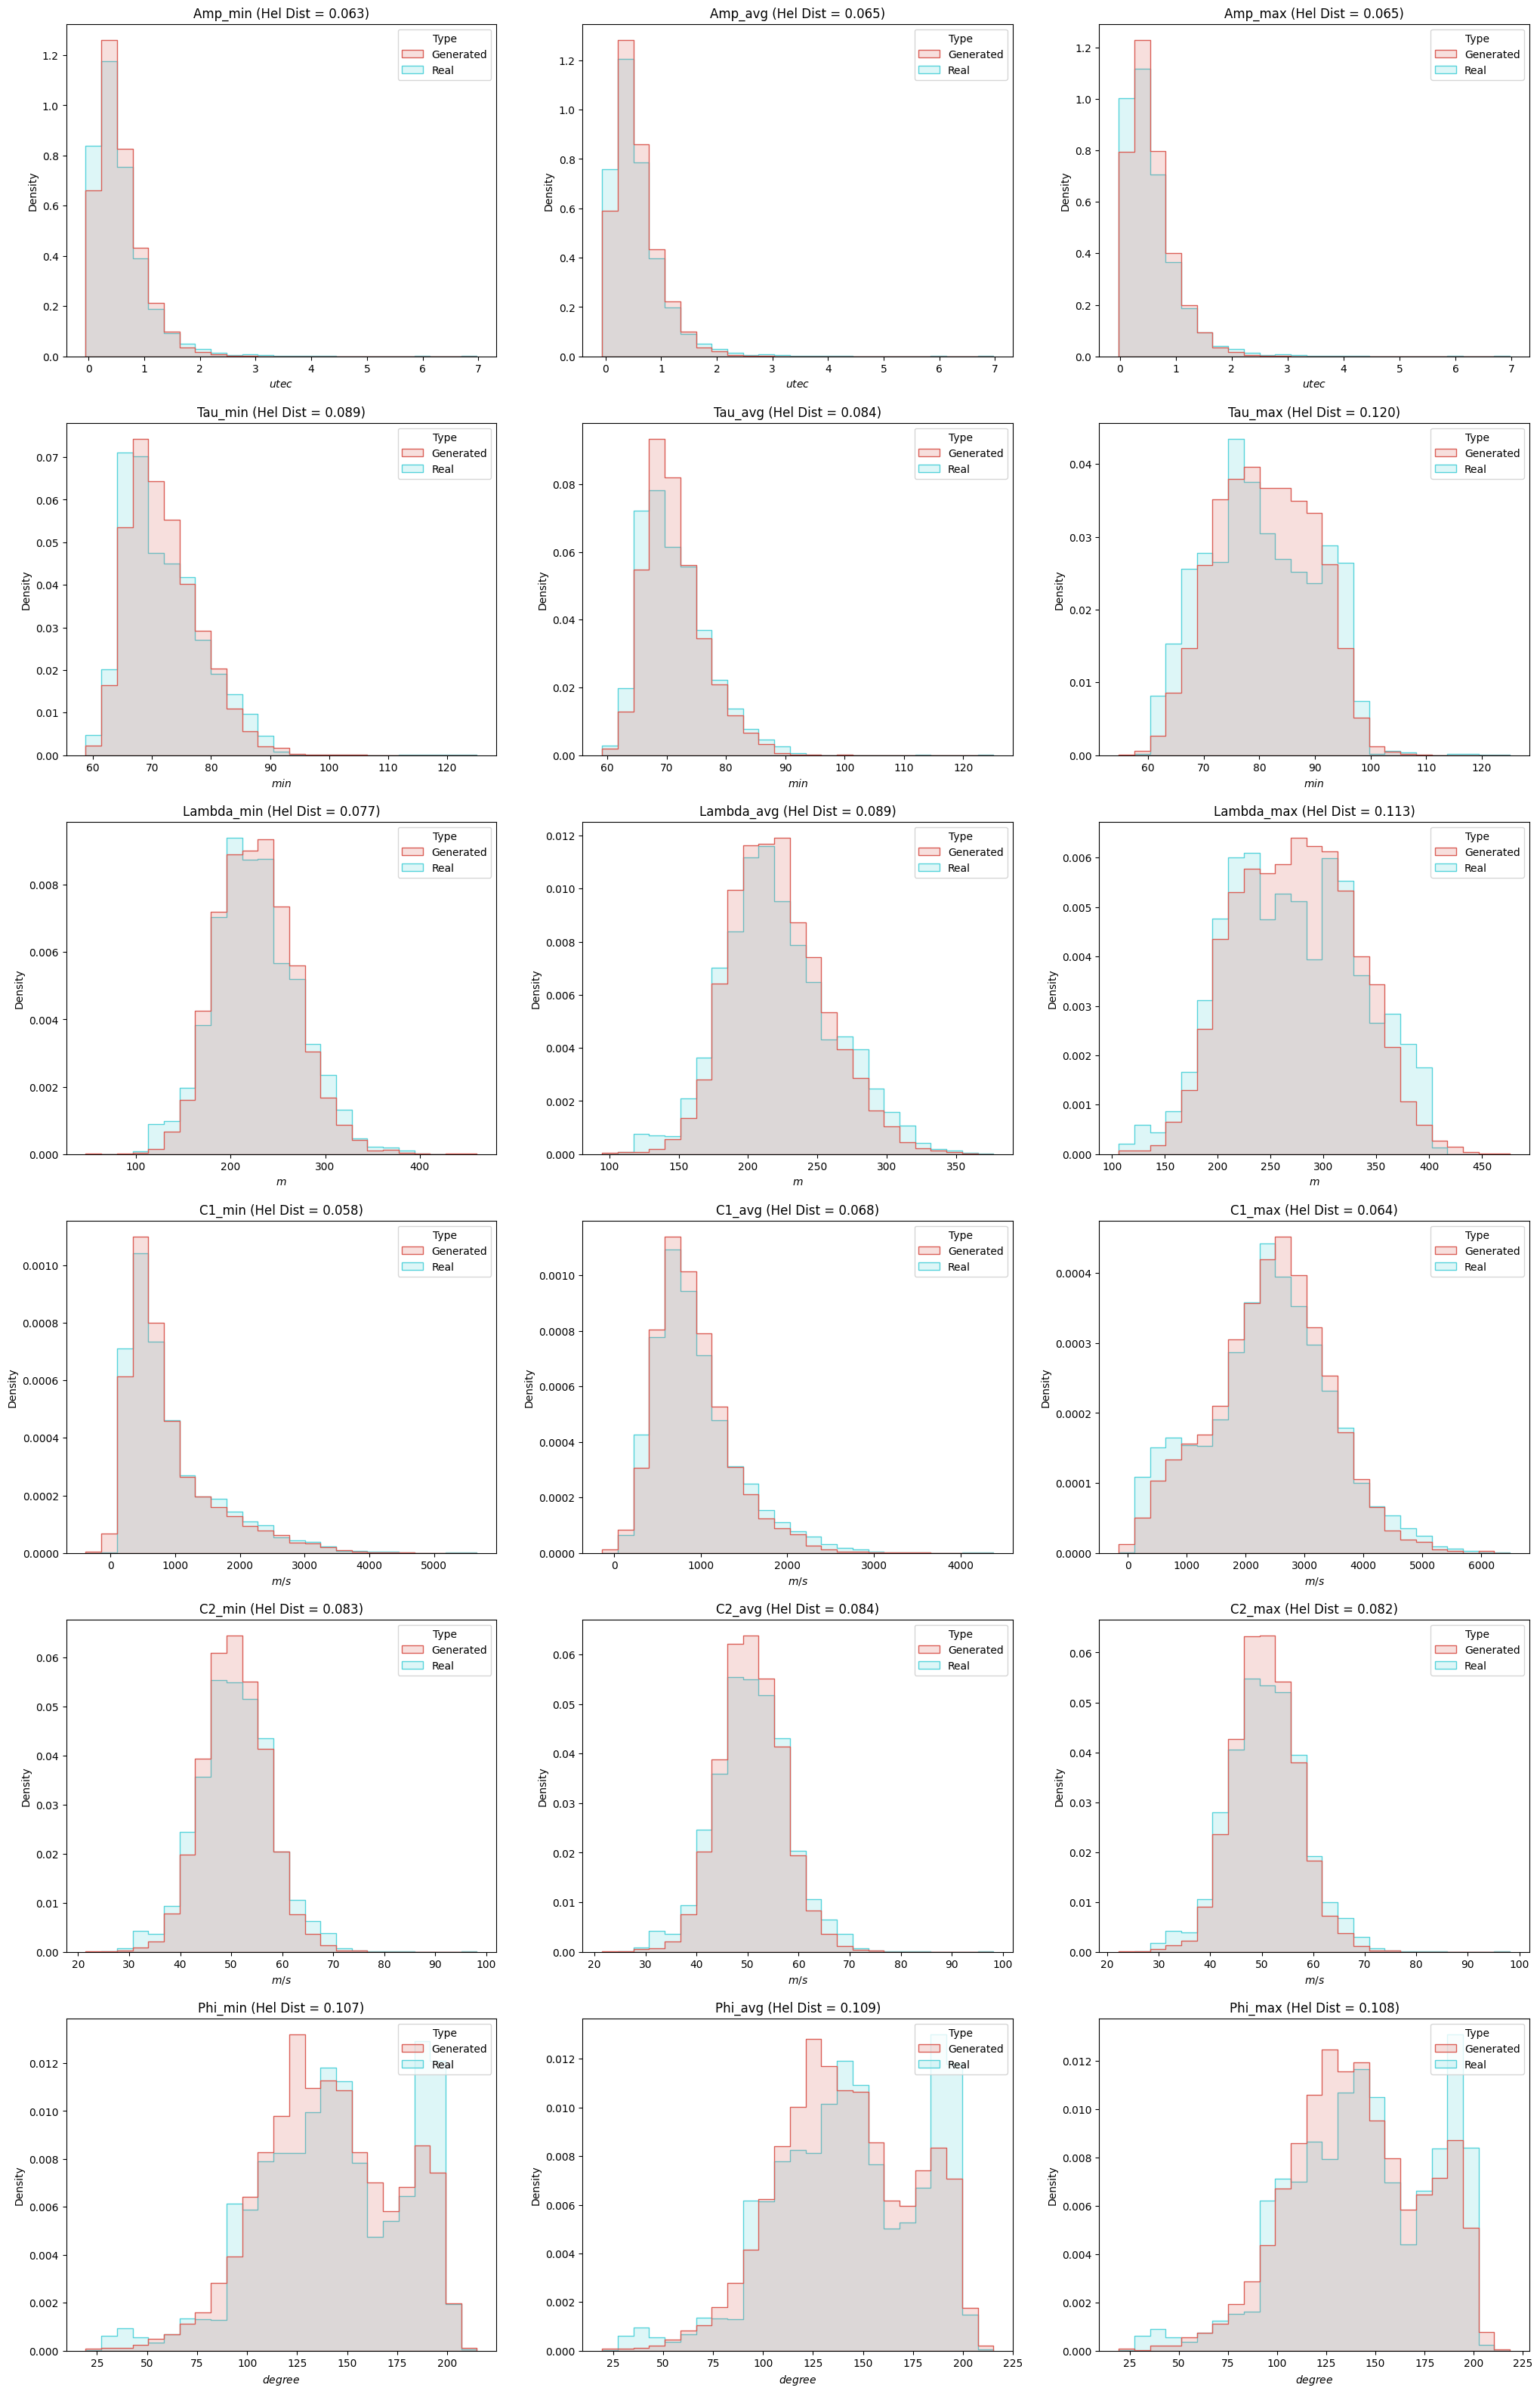

In [38]:
dists = hellinger_scores_wtec(wtec_lstids, G_wtec_lstids, dataset_name=dataset_name, filter_length=5)
print([f'{n} Dist: {d:.3f}' for (n, d) in zip(const.wtec_names, dists)])

plt.style.use('default')
fig, ax = plt.subplots(len(const.wtec_vars), 3, figsize=(25, 40))
ax = ax.flatten()
for i in range(len(ax)):
    x = np.hstack((wtec_lstids[... ,i].flatten(), G_wtec_lstids[..., i].flatten()))
    hue = ['Real'] * len(wtec_lstids[... ,i].flatten()) + ['Generated'] * len(G_wtec_lstids[..., i].flatten())
    data = pd.DataFrame({f'{const.wtec_units[i]}': x, 'Type': hue})
    sns.histplot(data=data, x=f'{const.wtec_units[i]}', hue='Type', ax=ax[i],
                 element='step', bins=25, legend=True, stat='density',
                 palette='hls', alpha=0.2, common_norm=False,
                 hue_order=['Generated', 'Real'])
    ax[i].set_title(f'{const.wtec_names[i]} (Hel Dist = {dists[i]:.3f})')
plt.show()

## TEC Wave anomaly scores

Again we can use the same techniques previously used on the ISR data to estimate anomaly scores for the observations in the TEC wave dataset. We first generate 1,000 samples for a particular external driver and then use our generated distribution to estimate anomaly scores. To generate the samples for each driver we call the `generate_multi_wtec` function passing in the drivers as conditioning. The multi generate function will produce  (n_samples, n_repeat, n_wtec). This is shown below for the first 500 samples to speed  things up.

You can then pass the sampled wave parameters into the `anomaly_score_wtec` function, which will perform the same joint anomaly score estimation that is performed with the HFP data. The `anomaly_score_wtec` function will estimate a anomaly score for each input sample based on the generated distribution. The plot below show the distribution of estimate anomaly scores produced from the wTEC GAN. The lower the score the more anomaly the observation is. Most of the scores sit around a score of 1, but you can see a couple samples in the left tail of the distribution with highly anomalous scores around -15.

Generating Samples: 100%|██████████| 500/500 [00:18<00:00, 27.11it/s]


Sampled wTECs shape: (500, 1000, 18)
wTEC anomaly Score Shape: (500,)
Average wTEC Score: 1.207


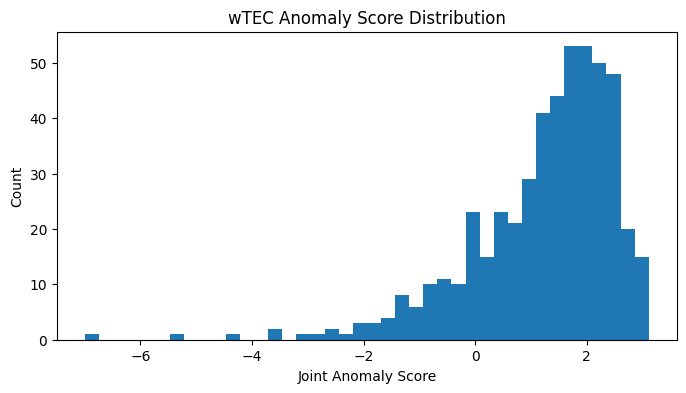

In [39]:
G_wtec_lstids = generate_multi_wtec(drivers=drivers[:500], n_repeat=1000, dataset_name=dataset_name, wtec_model=wtec_model, verbose=1)
print(f'Sampled wTECs shape: {G_wtec_lstids.shape}')

wtec_anomaly_scores = anomaly_score_wtec(wtec_lstids[:500], G_wtec_lstids, dataset_name=dataset_name)
print(f'wTEC anomaly Score Shape: {wtec_anomaly_scores.shape}')
print(f'Average wTEC Score: {np.mean(wtec_anomaly_scores):.3f}')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(wtec_anomaly_scores, bins=40)
ax.set_xlabel('Joint Anomaly Score')
ax.set_ylabel('Count')
ax.set_title('wTEC Anomaly Score Distribution')
plt.show()

## Mt Moses (MSTID Waves)

We also have an identical wTEC GAN trained to characterize medium transient ionospheric disturbances (MSTIDs) over Mt Moses in Nevada, which can use the name generation and anomaly score functions as we did for the Poker Flat's LSTIDs waves. Just make sure to pass the correct dataset name/model into the generator and other functions. To load the MSTIDs call the `load_wtec_h5` function and pass in the MSTID wave dataset file. The MSTIDs file for this tutorial contains observations during the year of 2016 as shown below.

Drivers Shape: (5000, 29)
wTEC Shape: (5000, 18)
Unix Timestamp Shape: (5000,)
wtEC Wave Parameter Names: ['Amp_min', 'Amp_avg', 'Amp_max', 'Tau_min', 'Tau_avg', 'Tau_max', 'Lambda_min', 'Lambda_avg', 'Lambda_max', 'C1_min', 'C1_avg', 'C1_max', 'C2_min', 'C2_avg', 'C2_max', 'Phi_min', 'Phi_avg', 'Phi_max']


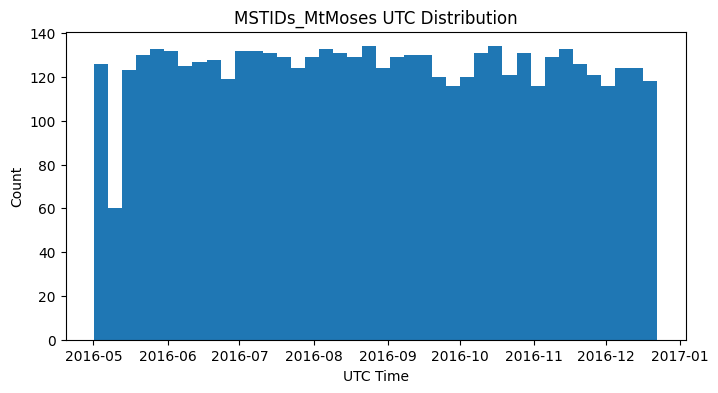

In [40]:
dataset_name = 'MSTIDs_MtMoses'
wtec_model = f'wtec_gan_{dataset_name}'
drivers, wtec_mstids, unix_time = load_wtec_h5(f'wtec_{dataset_name}.h5')
print(f'Drivers Shape: {drivers.shape}')
print(f'wTEC Shape: {wtec_mstids.shape}')
print(f'Unix Timestamp Shape: {unix_time.shape}')

print(f'wtEC Wave Parameter Names: {const.wtec_names}')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist([datetime.datetime.utcfromtimestamp(t) for t in unix_time], bins=40)
ax.set_ylabel("Count")
ax.set_xlabel('UTC Time')
ax.set_title(f'{dataset_name} UTC Distribution')
plt.show()

# G_wtec_mstids = generate_wtec(drivers=drivers, dataset_name=dataset_name, wtec_model=wtec_model)
# print(f'Generated wTEC {dataset_name} Shape: {G_wtec_mstids.shape}')
#
# dists = hellinger_scores_wtec(wtec_mstids, G_wtec_mstids, dataset_name=dataset_name, filter_length=2)
# print([f'{n} Dist: {d:.3f}' for (n, d) in zip(const.wtec_names, dists)])
#
#
# plt.style.use('default')
# fig, ax = plt.subplots(len(const.wtec_vars), 3, figsize=(25, 40))
# ax = ax.flatten()
# for i in range(len(ax)):
#     x = np.hstack((wtec_mstids[... ,i].flatten(), G_wtec_mstids[..., i].flatten()))
#     hue = ['Real'] * len(wtec_mstids[... ,i].flatten()) + ['Generated'] * len(G_wtec_mstids[..., i].flatten())
#     data = pd.DataFrame({f'{const.wtec_units[i]}': x, 'Type': hue})
#     sns.histplot(data=data, x=f'{const.wtec_units[i]}', hue='Type', ax=ax[i],
#                  element='step', bins=25, legend=True, stat='density',
#                  palette='hls', alpha=0.2, common_norm=False,
#                  hue_order=['Generated', 'Real'])
#     ax[i].set_title(f'{const.wtec_names[i]} (Hel Dist = {dists[i]:.3f})')
# plt.show()
#
#
# G_wtec_mstids = generate_multi_wtec(drivers=drivers[:500], n_repeat=1000, dataset_name=dataset_name, wtec_model=wtec_model, verbose=1)
# print(f'Sampled wTECs shape: {G_wtec_mstids.shape}')
#
# wtec_anomaly_scores = anomaly_score_wtec(wtec_mstids[:500], G_wtec_mstids, dataset_name=dataset_name)
# print(f'wTEC anomaly Score Shape: {wtec_anomaly_scores.shape}')
# print(f'Average wTEC Score: {np.mean(wtec_anomaly_scores):.3f}')
#
# fig, ax = plt.subplots(figsize=(8, 4))
# ax.hist(wtec_anomaly_scores, bins=40)
# ax.set_xlabel('Joint Anomaly Score')
# ax.set_ylabel('Count')
# ax.set_title('wTEC Anomaly Score Distribution')
# plt.show()

Generating TEC Waves: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


Generated wTEC MSTIDs_MtMoses Shape: (5000, 18)
['Amp_min Dist: 0.097', 'Amp_avg Dist: 0.092', 'Amp_max Dist: 0.093', 'Tau_min Dist: 0.142', 'Tau_avg Dist: 0.089', 'Tau_max Dist: 0.184', 'Lambda_min Dist: 0.113', 'Lambda_avg Dist: 0.094', 'Lambda_max Dist: 0.106', 'C1_min Dist: 0.112', 'C1_avg Dist: 0.097', 'C1_max Dist: 0.104', 'C2_min Dist: 0.111', 'C2_avg Dist: 0.111', 'C2_max Dist: 0.113', 'Phi_min Dist: 0.103', 'Phi_avg Dist: 0.103', 'Phi_max Dist: 0.100']


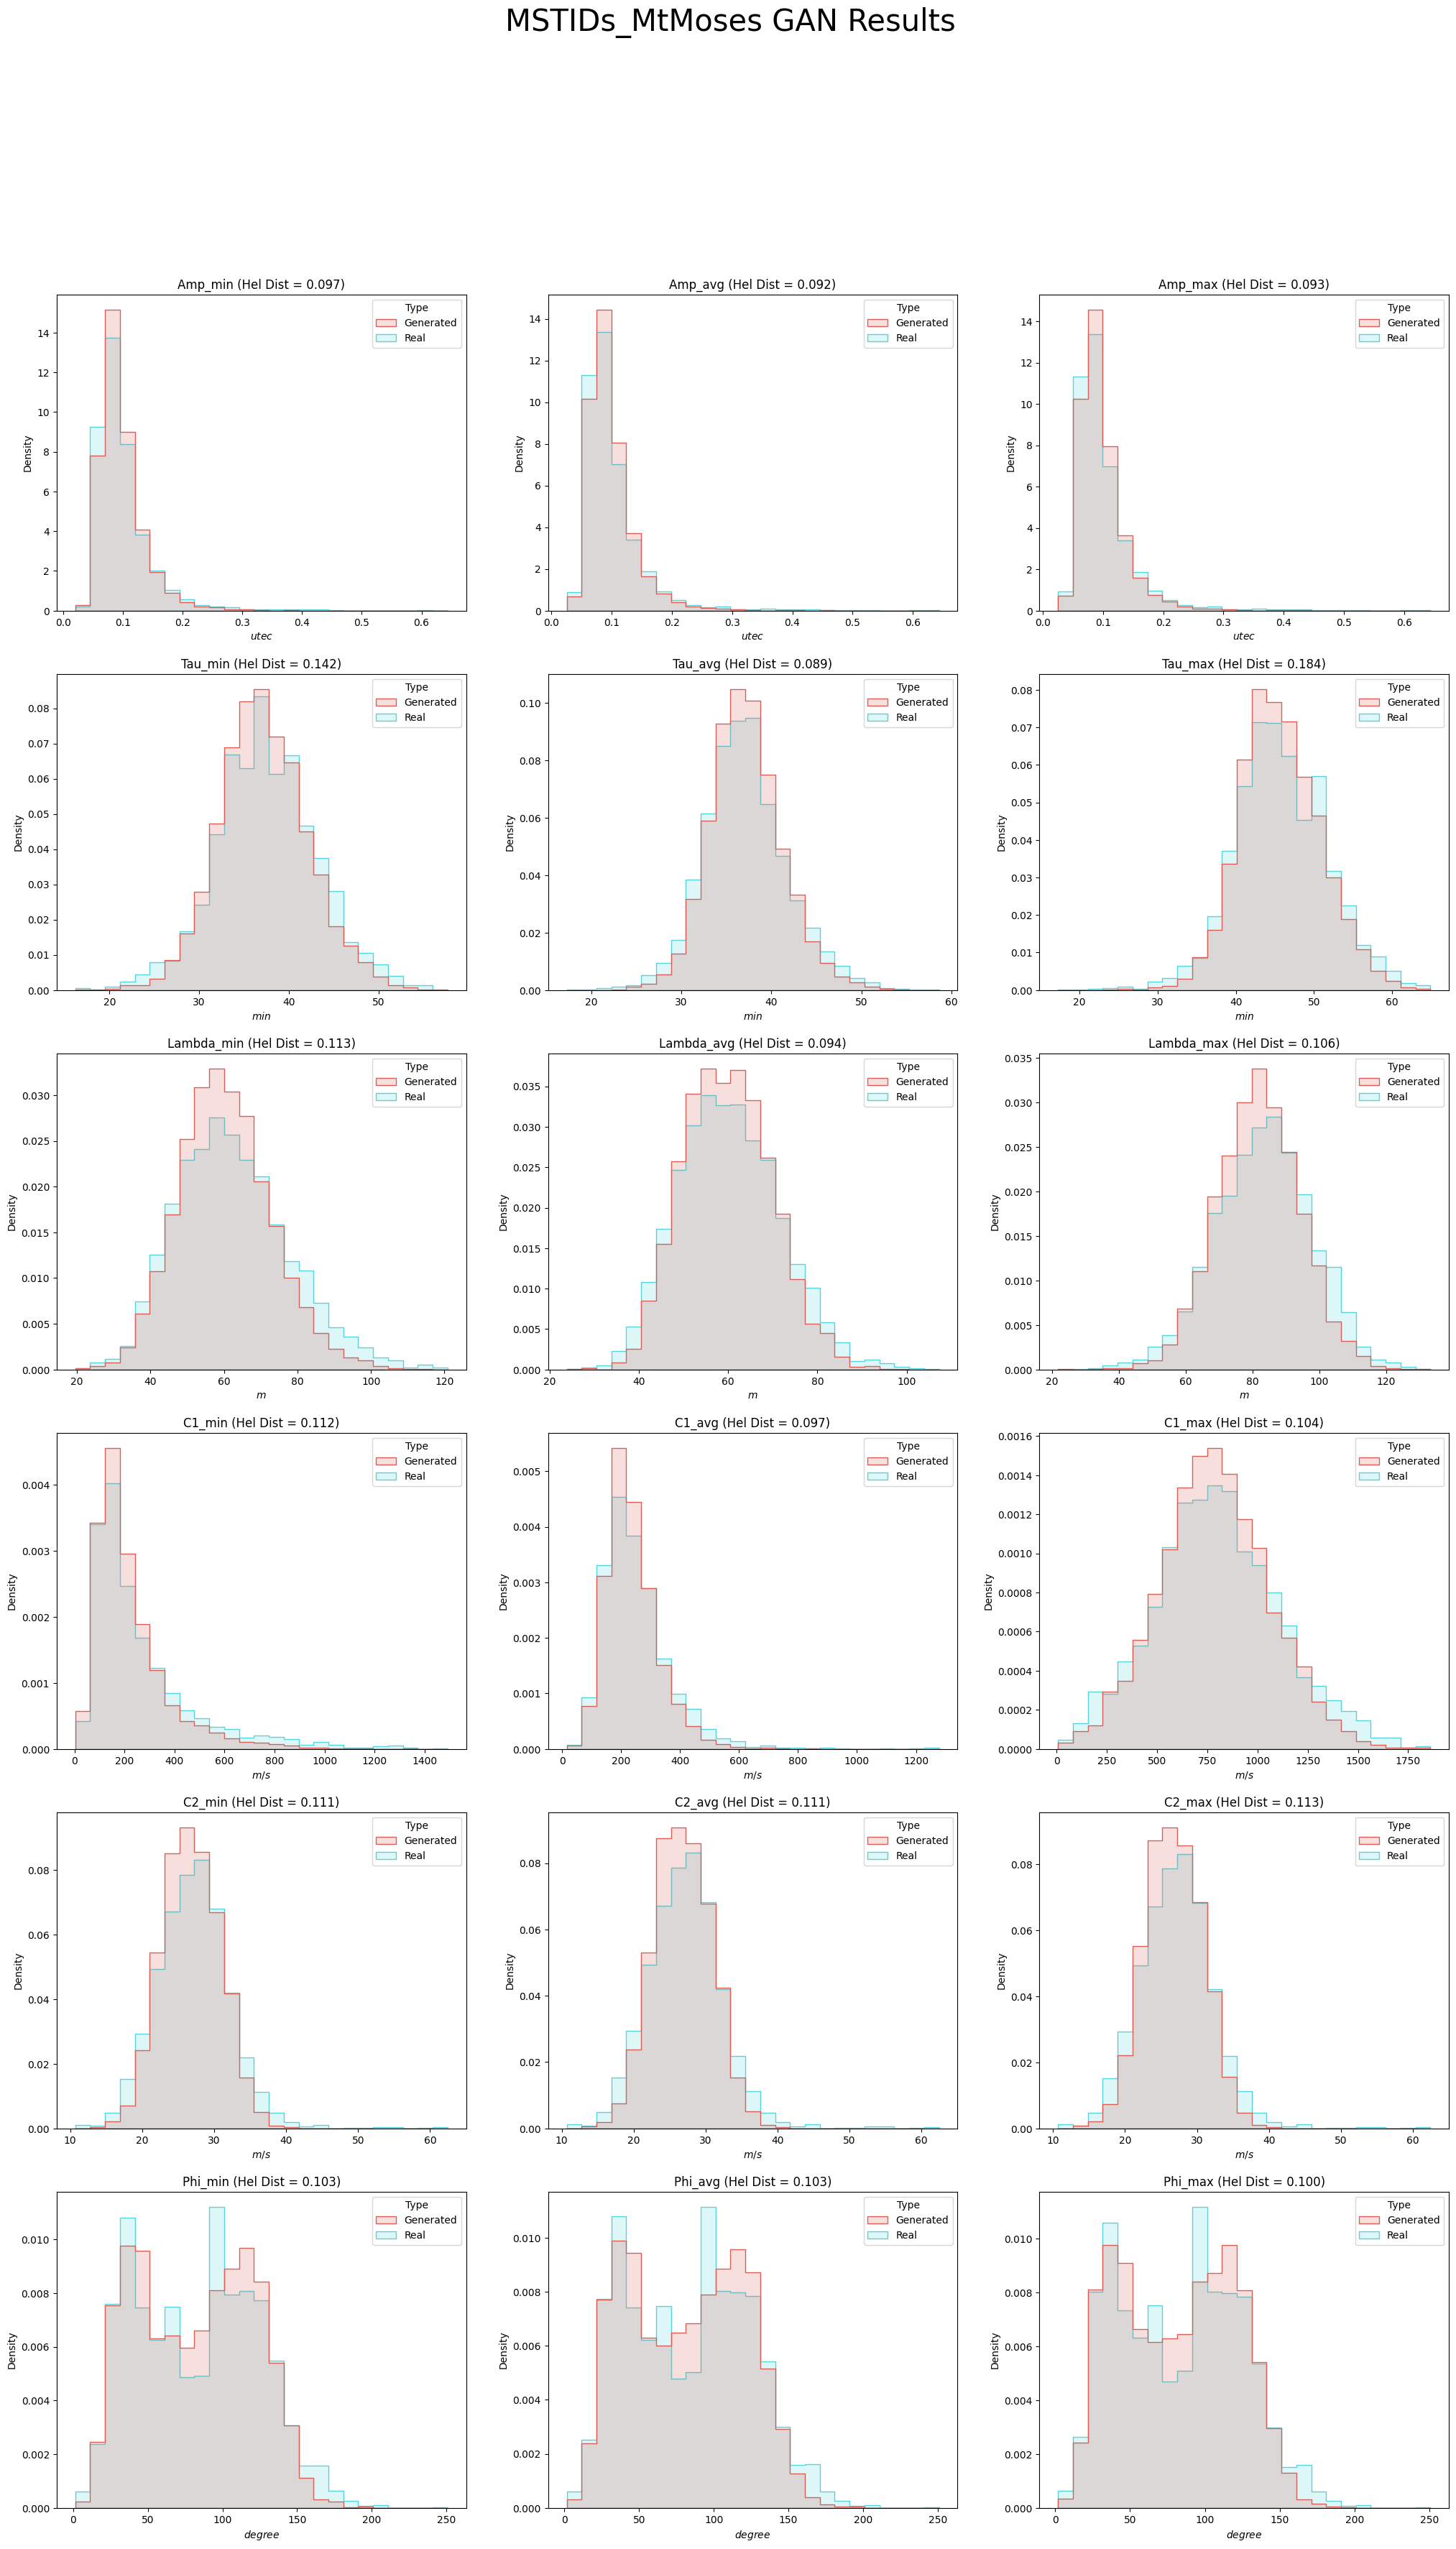

In [41]:
G_wtec_mstids = generate_wtec(drivers=drivers, dataset_name=dataset_name, wtec_model=wtec_model)
print(f'Generated wTEC {dataset_name} Shape: {G_wtec_mstids.shape}')

dists = hellinger_scores_wtec(wtec_mstids, G_wtec_mstids, dataset_name=dataset_name, filter_length=2)
print([f'{n} Dist: {d:.3f}' for (n, d) in zip(const.wtec_names, dists)])


plt.style.use('default')
fig, ax = plt.subplots(len(const.wtec_vars), 3, figsize=(25, 40))
ax = ax.flatten()
for i in range(len(ax)):
    x = np.hstack((wtec_mstids[... ,i].flatten(), G_wtec_mstids[..., i].flatten()))
    hue = ['Real'] * len(wtec_mstids[... ,i].flatten()) + ['Generated'] * len(G_wtec_mstids[..., i].flatten())
    data = pd.DataFrame({f'{const.wtec_units[i]}': x, 'Type': hue})
    sns.histplot(data=data, x=f'{const.wtec_units[i]}', hue='Type', ax=ax[i],
                 element='step', bins=25, legend=True, stat='density',
                 palette='hls', alpha=0.2, common_norm=False,
                 hue_order=['Generated', 'Real'])
    ax[i].set_title(f'{const.wtec_names[i]} (Hel Dist = {dists[i]:.3f})')
plt.suptitle(f'{dataset_name} GAN Results', fontsize=30)
plt.show()

Use the Mt Moses MSTID GAN to generate 500 sets of wave parameters for 200 drivers.

In [42]:
n_samples = 200
G_wtec_mstids = generate_multi_wtec(drivers=drivers[:n_samples], n_repeat=500, dataset_name=dataset_name, wtec_model=wtec_model, verbose=1)
print(f'Sampled wTECs shape: {G_wtec_mstids.shape}')

Generating Samples: 100%|██████████| 200/200 [02:23<00:00,  1.39it/s]

Sampled wTECs shape: (200, 500, 18)


Call the same `anomaly_score_wtec` function with the appropriate dataset name and generated PDFs to estimate anomaly scores for the medium scale TEC waves over Mt Moses.

wTEC anomaly Score Shape: (200,)
Average wTEC Score: -3.487


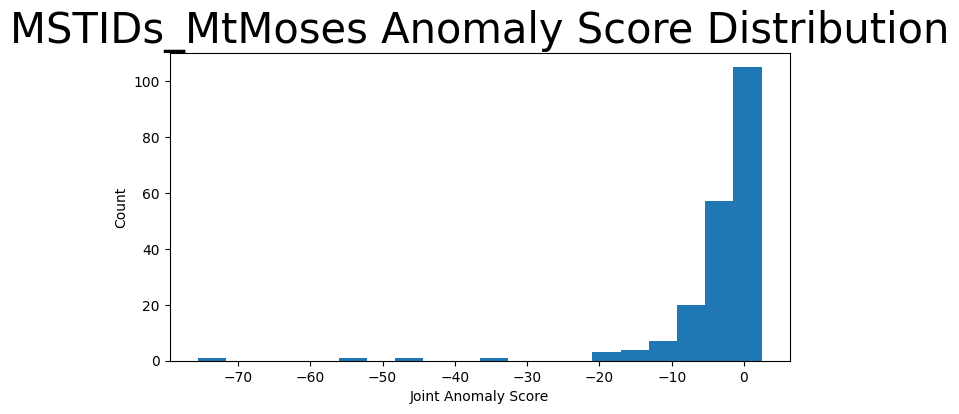

In [43]:
wtec_anomaly_scores = anomaly_score_wtec(wtec_mstids[:n_samples], G_wtec_mstids, dataset_name=dataset_name)
print(f'wTEC anomaly Score Shape: {wtec_anomaly_scores.shape}')
print(f'Average wTEC Score: {np.mean(wtec_anomaly_scores):.3f}')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(wtec_anomaly_scores, bins=20)
ax.set_xlabel('Joint Anomaly Score')
ax.set_ylabel('Count')
ax.set_title(f'{dataset_name} Anomaly Score Distribution', fontsize=30)
plt.show()